#The Weekend Effect of Mortality in Stroke Patients
Developed at the Hack Aotearoa 2020 datathon.

#Methodology Summary

Platform: Google Colab
Language: Python
Packages: pandas, numpy, statsmodels, tableone, mimiciii
Algorithm: generalised linear model

Data: MIMIC-III tables: clinical, derived. Merged on 'subject_id', 'hadm_id', 'icustay_id'

Data Processing: 
Dropping values:
1. All rows with null values in the icu9_code field since only stroke patients were studied.
2. Patient ages >= 90

Data Size: 4,322 incidents for 3,729 individual patients

Grouping by
1. Days of the week: Weekdays and weekends
2. Day of admission to ICU
2. Day of admission to Hospital
2. Ethnicity: White, black and other
3. Home Discharge: Home or to other health providers
4. Survival Period: short term < 6 months or long term >6 months
5. Admission type: emergency (emergency and urgent) or elective
6. GCS values: Mild -> GCS 13-15, Moderate -> GCS 9-12 OR Severe -> GCS 3-8

Model: 
Generalised Linear Model
binomial classifiers
Adjusted for age, gender and type of admission, 

#Imports and Installations

In [1]:
# Data processing libraries
import pandas as pd
import numpy as np
import itertools
import missingno as msno

# Stats libraries
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats

# Image libraries
import matplotlib.pyplot as plt


# Make pandas dataframes prettier
from IPython.display import display, HTML

# Access data using Google BigQuery.
import os
from google.colab import auth
from google.cloud import bigquery

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
import seaborn as sns

In [3]:
# install and import tableone
!pip install tableone
from tableone import TableOne

#MIMIC-III

##Connect to MIMIC-III

In [0]:
auth.authenticate_user()

In [0]:
# add your project ID for billing
project_id='hack-aotearoa'
os.environ["GOOGLE_CLOUD_PROJECT"]=project_id

##Extract Data

In [0]:
# Run query and assign the results to a Pandas DataFrame
# Requires the icustay_detail view from:
# https://github.com/MIT-LCP/mimic-code/tree/master/concepts/demographics
# And the OASIS score from:
# https://github.com/MIT-LCP/mimic-code/tree/master/concepts/severityscores
%%bigquery data

WITH first_icu AS (
    SELECT i.subject_id, i.hadm_id, i.icustay_id, i.gender, i.admittime admittime_hospital, 
      i.dischtime dischtime_hospital, i.los_hospital, i.admission_age, i.admission_type, 
      i.hospital_expire_flag, i.intime intime_icu, i.outtime outtime_icu, i.los_icu, 
      s.first_careunit
    FROM `physionet-data.mimiciii_derived.icustay_detail` i
    LEFT JOIN `physionet-data.mimiciii_clinical.icustays` s
    ON i.icustay_id = s.icustay_id
    WHERE i.hospstay_seq = 1
      AND i.icustay_seq = 1
      AND i.admission_age >= 16
)
SELECT f.*, o.icustay_expire_flag, o.oasis, o.oasis_prob
FROM first_icu f
LEFT JOIN `physionet-data.mimiciii_derived.oasis` o
ON f.icustay_id = o.icustay_id;

In [0]:
%%bigquery stroke_code

SELECT *
FROM `physionet-data.mimiciii_clinical.diagnoses_icd`
WHERE ICD9_CODE like '433%' or icd9_CODE like '434%' or icd9_CODE like '430%' or icd9_CODE like '431%' or icd9_CODE like '432%'
;

In [0]:
%%bigquery patients

SELECT *
FROM `physionet-data.mimiciii_clinical.patients`;

In [0]:
%%bigquery admissions

SELECT *
FROM `physionet-data.mimiciii_clinical.admissions`;

In [0]:
%%bigquery gcsfirstday

SELECT *
FROM `physionet-data.mimiciii_derived.gcsfirstday`;

##Load data into a single DataFrame

In [0]:
data.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'admittime_hospital',
       'dischtime_hospital', 'los_hospital', 'admission_age', 'admission_type',
       'hospital_expire_flag', 'intime_icu', 'outtime_icu', 'los_icu',
       'first_careunit', 'icustay_expire_flag', 'oasis', 'oasis_prob'],
      dtype='object')

In [0]:
stroke_code.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'SEQ_NUM', 'ICD9_CODE'], dtype='object')

In [0]:
patients.columns

Index(['ROW_ID', 'SUBJECT_ID', 'GENDER', 'DOB', 'DOD', 'DOD_HOSP', 'DOD_SSN',
       'EXPIRE_FLAG'],
      dtype='object')

In [0]:
admissions.columns

Index(['ROW_ID', 'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME',
       'DEATHTIME', 'ADMISSION_TYPE', 'ADMISSION_LOCATION',
       'DISCHARGE_LOCATION', 'INSURANCE', 'LANGUAGE', 'RELIGION',
       'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS',
       'HOSPITAL_EXPIRE_FLAG', 'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [0]:
gcsfirstday.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ICUSTAY_ID', 'MinGCS', 'GCSMotor',
       'GCSVerbal', 'GCSEyes', 'EndoTrachFlag'],
      dtype='object')

In [0]:
#Rename columns to remove capitalization
stroke_code = stroke_code.rename(columns={'ROW_ID':'row_id', 'SUBJECT_ID':'subject_id', 'HADM_ID':'hadm_id', 'SEQ_NUM':'seq_num', 'ICD9_CODE':'icd9_code'})

patients = patients.rename(columns={'ROW_ID':'row_id', 'SUBJECT_ID':'subject_id', 'GENDER':'gender', 'DOB':'dob', 'DOD':'dod', 'DOD_HOSP':'dod_hosp', 'DOD_SSN':'dod_ssn', 'EXPIRE_FLAG':'expire_flag'})

admissions = admissions.rename(columns={'ROW_ID':'row_id', 'SUBJECT_ID':'subject_id', 'HADM_ID':'hadm_id', 'ADMITTIME':'admittime', 'DISCHTIME':'dischtime',
       'DEATHTIME':'deathtime', 'ADMISSION_TYPE':'admission_type', 'ADMISSION_LOCATION':'admission_location',
       'DISCHARGE_LOCATION':'discharge_location', 'INSURANCE':'insurance', 'LANGUAGE':'language', 'RELIGION':'religion',
       'MARITAL_STATUS':'marital_status', 'ETHNICITY':'ethnicity', 'EDREGTIME':'edregtime', 'EDOUTTIME':'edouttime', 'DIAGNOSIS':'diagnosis',
       'HOSPITAL_EXPIRE_FLAG':'hospital_expire_flag', 'HAS_CHARTEVENTS_DATA':'has_chartevents_data'})

gcsfirstday = gcsfirstday.rename(columns={'SUBJECT_ID':'subject_id', 'HADM_ID':'hadm_id', 'ICUSTAY_ID':'icustay_id', 'MinGCS':'mingcs', 'GCSMotor':'gcsmotor', 'GCSVerbal':'gcsverbal', 'GCSEyes':'gcseyes', 'EndoTrachFlag':'endotrachflag'})

In [0]:
stroke_code.columns, patients.columns, admissions.columns, gcsfirstday.columns

(Index(['row_id', 'subject_id', 'hadm_id', 'seq_num', 'icd9_code'], dtype='object'),
 Index(['row_id', 'subject_id', 'gender', 'dob', 'dod', 'dod_hosp', 'dod_ssn',
        'expire_flag'],
       dtype='object'),
 Index(['row_id', 'subject_id', 'hadm_id', 'admittime', 'dischtime',
        'deathtime', 'admission_type', 'admission_location',
        'discharge_location', 'insurance', 'language', 'religion',
        'marital_status', 'ethnicity', 'edregtime', 'edouttime', 'diagnosis',
        'hospital_expire_flag', 'has_chartevents_data'],
       dtype='object'),
 Index(['subject_id', 'hadm_id', 'icustay_id', 'mingcs', 'gcsmotor',
        'gcsverbal', 'gcseyes', 'endotrachflag'],
       dtype='object'))

In [0]:
data.shape, stroke_code.shape, admissions.shape, gcsfirstday.shape

((38558, 17), (5386, 5), (58976, 19), (61532, 8))

In [0]:
df = pd.merge(data, stroke_code, how='left', on=['subject_id', 'hadm_id'])

#Data Processing

##Dropping Null Values

In [0]:
df.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender', 'admittime_hospital',
       'dischtime_hospital', 'los_hospital', 'admission_age', 'admission_type',
       'hospital_expire_flag', 'intime_icu', 'outtime_icu', 'los_icu',
       'first_careunit', 'icustay_expire_flag', 'oasis', 'oasis_prob',
       'row_id', 'seq_num', 'icd9_code'],
      dtype='object')

In [0]:
df.shape

(39187, 20)

In [0]:
#Check the various categories in icd9_code data
df.icd9_code.sort_values().unique()

array(['430', '431', '4320', '4321', '4329', '43300', '43301', '43310',
       '43311', '43320', '43321', '43330', '43331', '43380', '43381',
       '43391', '43400', '43401', '43410', '43411', '43490', '43491', nan],
      dtype=object)

These codes correspond to stroke patients

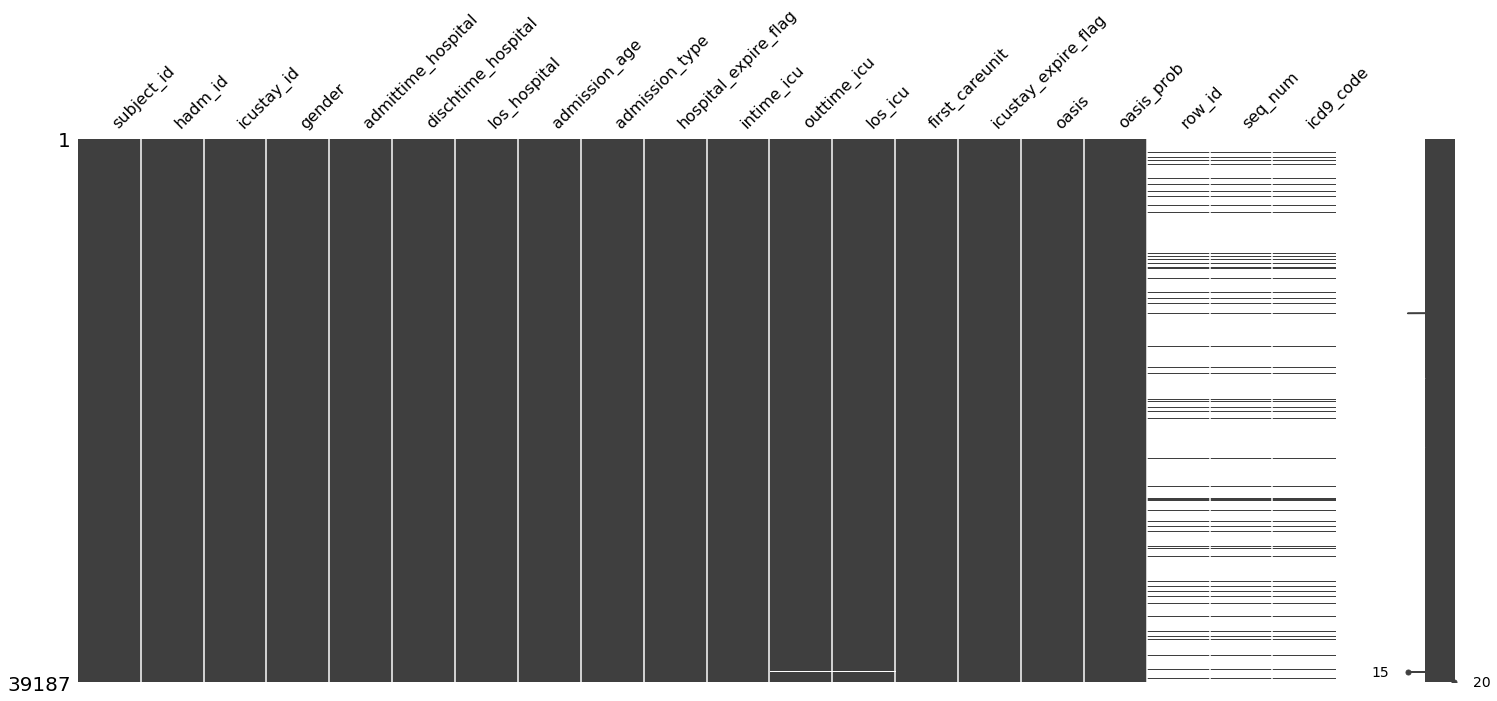

In [0]:
#Visualise the null values
msno.matrix(df)

Several null values are present in row_id, seq_num and icd9_code. Minimal null values are present in outcome_icu and los_icu

In [0]:
#Identify rows without NaN values
nonnan_rows_age = df[df['icd9_code'].isnotnull()]
nan_rows_age

In [0]:
#Drop the Null values of icd9_code
data = df.dropna(subset=['icd9_code'])

In [0]:
data.shape

(4585, 20)

Dropping the data without icd9_code values reduces the data frame from 39,187 to 4,585. It will be seen later that this corresponds to 3,729 individual patients. This was later observed to be a case of data duplication which is taken care of consequently. Details are provided in 'Dropping duplicate data' below.

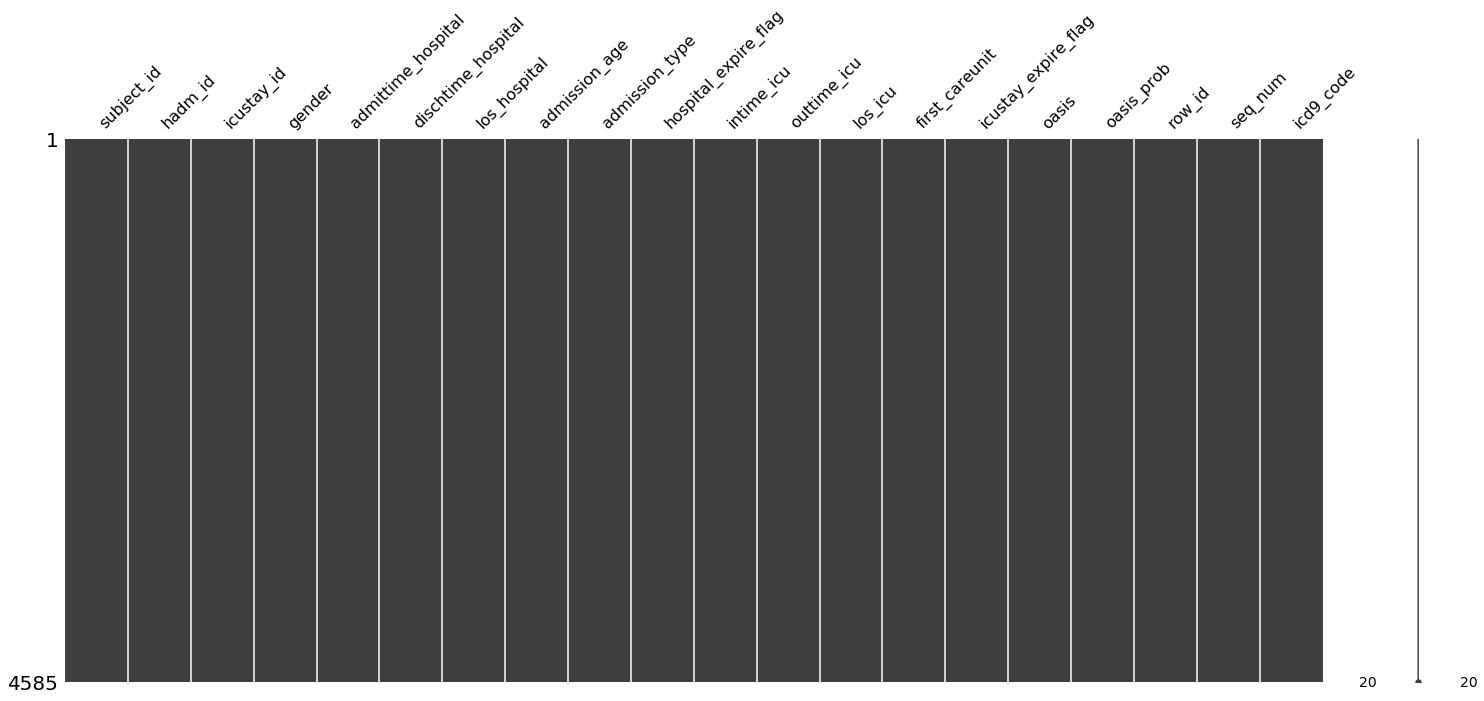

In [0]:
#Visualise the null values
msno.matrix(data)

All the null values have been taken care of.

##Dropping patients aged >= 90

In [0]:
data1 = data[data.admission_age < 300]
data1.shape

(4322, 20)

In [0]:
data.shape[0] - data1.shape[0]

263

Another 263 patients ($5.74\%$ of 4,585) have been removed.

##Merging the remaining DFs into a single DF

In [0]:
data2 = pd.merge(data1, patients, how='left', on=['subject_id'])
data1.shape, data2.shape

((4322, 20), (4322, 27))

In [0]:
data3 = pd.merge(data2, admissions, how='left', on=['subject_id', 'hadm_id'])
data1.shape, data2.shape, data3.shape

((4322, 20), (4322, 27), (4322, 44))

In [0]:
data4 = pd.merge(data3, gcsfirstday, how='left', on=['subject_id', 'hadm_id', 'icustay_id'])
data1.shape, data2.shape, data3.shape, data4.shape

((4322, 20), (4322, 27), (4322, 44), (4322, 49))

##Dropping duplicated data

In [0]:
#Check whether there are patients who were admitted repeatedly using subject_id
data4['subject_id'].value_counts(dropna=False)[:20] #Top 20

68764    5
89901    5
55689    4
93394    3
42894    3
16227    3
4814     3
9471     3
46303    3
50358    3
99863    3
61207    3
27972    3
77579    3
31191    3
40513    3
30063    3
31476    3
65237    3
83963    3
Name: subject_id, dtype: int64

In [0]:
#Check the sample of one patient
data4.loc[data4['subject_id'] == 9471]

,subject_id,hadm_id,icustay_id,gender_x,admittime_hospital,dischtime_hospital,los_hospital,admission_age,admission_type_x,hospital_expire_flag_x,intime_icu,outtime_icu,los_icu,first_careunit,icustay_expire_flag,oasis,oasis_prob,row_id_x,seq_num,icd9_code,row_id_y,gender_y,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,admittime,dischtime,deathtime,admission_type_y,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag_y,has_chartevents_data,mingcs,gcsmotor,gcsverbal,gcseyes,endotrachflag,admitday_hospital,dischday_hospital,inday_icu,inday_icu_seq,outday_icu,inday_icu_wkd,survival_time,death_post_discharge_in_days,survival_time_flag,home_discharge_bool,adm_type_2,adm_type_2_bool,home_discharge_flag
3694,9471,129609,237383,F,2184-12-10 06:55:00,2185-01-08 18:50:00,29,44,EMERGENCY,0,2184-12-10 06:56:16,2185-01-05 03:17:39,26.0,SICU,0,41,0.279468,106246.0,1.0,430,8963,F,2140-03-05,NaT,NaT,NaT,0,11594,2184-12-10 06:55:00,2185-01-08 18:50:00,None,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicaid,None,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,NaT,NaT,SUBARACHNOID HEMORRHAGE,0,1,11.0,5.0,3.0,3.0,0.0,Friday,Saturday,Friday,4,Wednesday,weekday,NaT,long_survival,0,True,emergency,1,1
3695,9471,129609,237383,F,2184-12-10 06:55:00,2185-01-08 18:50:00,29,44,EMERGENCY,0,2184-12-10 06:56:16,2185-01-05 03:17:39,26.0,SICU,0,41,0.279468,106248.0,3.0,43331,8963,F,2140-03-05,NaT,NaT,NaT,0,11594,2184-12-10 06:55:00,2185-01-08 18:50:00,None,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicaid,None,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,NaT,NaT,SUBARACHNOID HEMORRHAGE,0,1,11.0,5.0,3.0,3.0,0.0,Friday,Saturday,Friday,4,Wednesday,weekday,NaT,long_survival,0,True,emergency,1,1
3696,9471,129609,237383,F,2184-12-10 06:55:00,2185-01-08 18:50:00,29,44,EMERGENCY,0,2184-12-10 06:56:16,2185-01-05 03:17:39,26.0,SICU,0,41,0.279468,106249.0,4.0,43491,8963,F,2140-03-05,NaT,NaT,NaT,0,11594,2184-12-10 06:55:00,2185-01-08 18:50:00,None,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicaid,None,NOT SPECIFIED,SINGLE,BLACK/AFRICAN AMERICAN,NaT,NaT,SUBARACHNOID HEMORRHAGE,0,1,11.0,5.0,3.0,3.0,0.0,Friday,Saturday,Friday,4,Wednesday,weekday,NaT,long_survival,0,True,emergency,1,1


All the rows are identical to each other. This is data repetition and should be deleted.

In [0]:
data4 = data4.drop_duplicates(subset='subject_id', keep='first')
data4.shape

(3729, 62)

In [0]:
#Test to see if this worked
#Check whether there are patients who were admitted repeatedly using subject_id
data4['subject_id'].value_counts(dropna=False)

24572    1
70339    1
8929     1
19168    1
23258    1
        ..
25886    1
9813     1
17690    1
7449     1
32768    1
Name: subject_id, Length: 3729, dtype: int64

#Data Investigation

##Investgation of current data

In [0]:
data4.head()

,subject_id,hadm_id,icustay_id,gender_x,admittime_hospital,dischtime_hospital,los_hospital,admission_age,admission_type_x,hospital_expire_flag_x,intime_icu,outtime_icu,los_icu,first_careunit,icustay_expire_flag,oasis,oasis_prob,row_id_x,seq_num,icd9_code,row_id_y,gender_y,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,admittime,dischtime,deathtime,admission_type_y,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag_y,has_chartevents_data,mingcs,gcsmotor,gcsverbal,gcseyes,endotrachflag,admitday_hospital,dischday_hospital,inday_icu,inday_icu_seq,outday_icu,inday_icu_wkd,survival_time,death_post_discharge_in_days,survival_time_flag,home_discharge_bool,adm_type_2,adm_type_2_bool,home_discharge_flag
0,141,168006,234668,M,2140-11-06 11:07:00,2140-11-09 20:36:00,3,80,EMERGENCY,1,2140-11-06 11:09:19,2140-11-09 22:35:29,3.0,MICU,1,53,0.641734,1784.0,2.0,43491,131,M,2060-05-03,2140-11-09,2140-11-09,2140-11-09,1,190,2140-11-06 11:07:00,2140-11-09 20:36:00,2140-11-09 20:36:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,OTHER,SINGLE,OTHER,2140-11-06 07:17:00,2140-11-06 12:07:00,"DRA, SAH",1,1,14.0,6.0,4.0,4.0,0.0,Sunday,Wednesday,Sunday,6,Wednesday,weekend,-1 days +03:24:00,short_survival,1,False,emergency,1,0
1,416,148709,226936,F,2132-07-23 14:46:00,2132-08-11 17:19:00,19,56,EMERGENCY,0,2132-07-23 14:47:03,2132-08-08 17:03:29,16.0,MICU,0,55,0.698023,5023.0,1.0,430,392,F,2076-12-12,2136-11-11,NaT,2136-11-11,1,532,2132-07-23 14:46:00,2132-08-11 17:19:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,HAIT,UNOBTAINABLE,MARRIED,BLACK/AFRICAN AMERICAN,2132-07-23 09:26:00,2132-07-23 15:08:00,SAH,0,1,13.0,6.0,4.0,3.0,0.0,Wednesday,Monday,Wednesday,2,Friday,weekday,1552 days 06:41:00,long_survival,0,True,emergency,1,1
2,490,166850,222952,M,2199-12-12 19:04:00,2199-12-13 20:33:00,1,87,EMERGENCY,1,2199-12-12 21:15:58,2199-12-13 20:33:59,1.0,SICU,1,58,0.772134,5788.0,1.0,43491,463,M,2112-11-20,2199-12-13,2199-12-13,2199-12-13,1,615,2199-12-12 19:04:00,2199-12-13 20:33:00,2199-12-13 20:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,2199-12-12 17:13:00,2199-12-12 22:06:00,CEREBRAL VASCULAR ACCIDENT,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Friday,Thursday,3,Friday,weekday,-1 days +03:27:00,short_survival,1,False,emergency,1,0
4,831,185983,223445,F,2151-06-30 09:44:00,2151-07-15 13:50:00,15,84,EMERGENCY,0,2151-06-30 09:44:47,2151-07-03 18:15:14,3.0,SICU,0,51,0.581248,9671.0,1.0,431,784,F,2067-05-06,2151-09-10,NaT,2151-09-10,1,1031,2151-06-30 09:44:00,2151-07-15 13:50:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,None,JEWISH,WIDOWED,WHITE,2151-06-30 08:22:00,2151-06-30 11:10:00,STROKE/TIA,0,1,7.0,4.0,1.0,2.0,0.0,Wednesday,Thursday,Wednesday,2,Saturday,weekday,56 days 10:10:00,short_survival,1,False,emergency,1,0
5,1054,183383,288218,M,2157-01-06 17:16:00,2157-01-08 15:00:00,2,79,EMERGENCY,1,2157-01-06 17:17:38,2157-01-07 22:01:06,1.0,SICU,0,51,0.581248,12291.0,1.0,430,998,M,2078-07-15,2157-01-08,2157-01-08,NaT,1,1310,2157-01-06 17:16:00,2157-01-08 15:00:00,2157-01-08 15:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,PROTESTANT QUAKER,MARRIED,WHITE,2157-01-06 14:49:00,2157-01-06 18:36:00,INTRACRANIAL HEMORRHAGE,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Saturday,Thursday,3,Friday,weekday,-1 days +09:00:00,short_survival,1,False,emergency,1,0


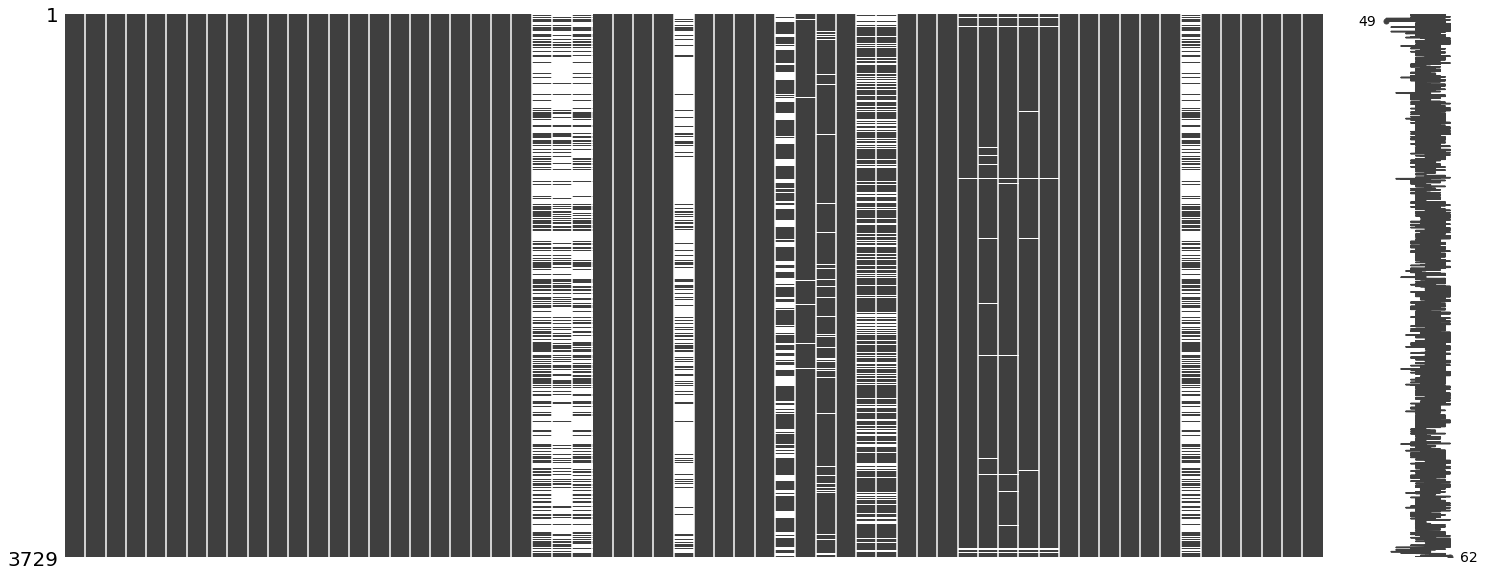

In [0]:
#Null values check
msno.matrix(data4)

In [0]:
data4.describe().T

,count,mean,std,min,25%,50%,75%,max
subject_id,3729,40924.9,29382.9,9,16227,30588,66105,99955
hadm_id,3729,149722,29021.9,100018,124812,149148,175432,199972
icustay_id,3729,250115,29134.3,200019,224615,249559,275601,299973
los_hospital,3729,11.2448,11.568,0,4,8,15,132
admission_age,3729,66.7989,14.7602,17,57,69,79,89
hospital_expire_flag_x,3729,0.214803,0.410741,0,0,0,0,1
los_icu,3729,5.40949,6.9967,0,1,3,6,65
icustay_expire_flag,3729,0.157683,0.364492,0,0,0,0,1
oasis,3729,32.1124,8.78685,7,26,32,38,66
oasis_prob,3729,0.155017,0.143251,0.00505605,0.0541872,0.109623,0.209226,0.903819


In [0]:
#Investigate contents to identify categorical and continuous data
for col in data4:
   print(data4[col].value_counts(dropna=False))

24572    1
70339    1
8929     1
19168    1
23258    1
        ..
25886    1
9813     1
17690    1
7449     1
32768    1
Name: subject_id, Length: 3729, dtype: int64
105023    1
148153    1
115417    1
191192    1
115409    1
         ..
118131    1
140658    1
101743    1
198603    1
114688    1
Name: hadm_id, Length: 3729, dtype: int64
239615    1
221897    1
285406    1
201251    1
256732    1
         ..
204157    1
284028    1
214394    1
261497    1
204800    1
Name: icustay_id, Length: 3729, dtype: int64
M    2017
F    1712
Name: gender_x, dtype: int64
2184-12-17 21:15:00    1
2140-04-28 00:20:00    1
2119-12-20 12:45:00    1
2177-04-06 16:11:00    1
2108-12-07 03:57:00    1
                      ..
2113-01-15 15:59:00    1
2195-03-10 07:15:00    1
2182-08-28 22:48:00    1
2140-05-24 07:15:00    1
2191-09-28 19:45:00    1
Name: admittime_hospital, Length: 3729, dtype: int64
2165-10-22 14:20:00    2
2141-04-07 17:30:00    2
2184-11-11 20:18:00    1
2173-06-27 08:56:00    1
2116-0

##Investigation of death-related data

In [31]:
#Filter all death-related data for cases where death occurred in the ICU. List the first 10 such cases
data4[['hospital_expire_flag_x', 'icustay_expire_flag', 'outtime_icu', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'deathtime', 'discharge_location']].query('icustay_expire_flag == 1')[:10]

,hospital_expire_flag_x,icustay_expire_flag,outtime_icu,dod,dod_hosp,dod_ssn,expire_flag,deathtime,discharge_location
0,1,1,2140-11-09 22:35:29,2140-11-09,2140-11-09,2140-11-09,1,2140-11-09 20:36:00,DEAD/EXPIRED
2,1,1,2199-12-13 20:33:59,2199-12-13,2199-12-13,2199-12-13,1,2199-12-13 20:33:00,DEAD/EXPIRED
7,1,1,2189-01-03 01:37:51,2189-01-02,2189-01-02,2189-01-02,1,2189-01-02 12:00:00,DEAD/EXPIRED
8,1,1,2184-07-24 17:58:01,2184-07-24,2184-07-24,2184-07-24,1,2184-07-24 15:38:00,DEAD/EXPIRED
10,1,1,2150-04-07 23:17:27,2150-04-07,2150-04-07,NaT,1,2150-04-07 19:30:00,DEAD/EXPIRED
12,1,1,2166-02-13 07:38:37,2166-02-12,2166-02-12,NaT,1,2166-02-12 12:00:00,DEAD/EXPIRED
13,1,1,2150-01-01 17:21:58,2150-01-01,2150-01-01,2150-01-01,1,2150-01-01 13:22:00,DEAD/EXPIRED
15,1,1,2134-02-17 00:37:28,2134-02-16,2134-02-16,2134-02-16,1,2134-02-16 12:00:00,DEAD/EXPIRED
20,1,1,2158-11-19 16:49:34,2158-11-19,2158-11-19,2158-11-19,1,2158-11-19 14:27:00,DEAD/EXPIRED
22,1,1,2137-05-13 17:31:51,2137-05-13,2137-05-13,2137-05-17,1,2137-05-13 16:03:00,DEAD/EXPIRED


The above shows that in all cases where death occurred in the ICU (indicated by *icustay_expire_flag* and *outtime_icu*), it was also registered as a hospital death (indicated by the values of *hospital_expire_flag_x* and *dod_hosp*).

In [30]:
#Verify whether there are any cases where death occurred in the ICU but was not registered as a hospital death
data4[['hospital_expire_flag_x', 'icustay_expire_flag', 'outtime_icu', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag', 'deathtime', 'discharge_location']].query('icustay_expire_flag == 1 and hospital_expire_flag_x == 0')

,hospital_expire_flag_x,icustay_expire_flag,outtime_icu,dod,dod_hosp,dod_ssn,expire_flag,deathtime,discharge_location


The resulting table above is empty indicating that there are no cases where ICU death was not registered as hospital death. In other words, all ICU deaths were also recorded as hospital deaths.

##Addition of Categorical Features

In [0]:
#Add columns for days of the week
data4['admitday_hospital'] = data4.admittime_hospital.dt.weekday_name
data4['dischday_hospital'] = data4.dischtime_hospital.dt.weekday_name
data4['inday_icu'] = data4.intime_icu.dt.weekday_name
data4['inday_icu_seq'] = data4.intime_icu.dt.weekday
data4['outday_icu'] = data4.outtime_icu.dt.weekday_name

In [0]:
data4['inday_icu'].value_counts()

Friday       599
Monday       587
Tuesday      575
Thursday     561
Wednesday    549
Sunday       447
Saturday     411
Name: inday_icu, dtype: int64

In [0]:
data4['inday_icu_wkd'] = np.where(data4.intime_icu.dt.weekday <= 4, 
                                 'weekday','weekend')
data4['inday_icu_wkd'].value_counts()

weekday    2871
weekend     858
Name: inday_icu_wkd, dtype: int64

In [0]:
#Create a new column consisting of the first 3 characters of the ICD9 code as an integer
data4['icd9_num'] = data4.icd9_code.str[:3].astype(int)
#Create a new column that identifies the type of stroke
data4['stroke_type'] = np.where(data4.icd9_num <= 432, 'haemorrage','ischemic')

#Table One

In [0]:
#Table One
columns = ['gender_x', 'los_hospital', 'admission_age', 'admission_type_x', 'hospital_expire_flag_x', 
           'los_icu','icustay_expire_flag', 'oasis', 'oasis_prob', 'first_careunit',
           'inday_icu_wkd']

groupby = 'inday_icu'

pval = False

categorical = ['gender_x','admission_type_x','hospital_expire_flag_x','icustay_expire_flag',
               'first_careunit','inday_icu_wkd']

t = TableOne(data4, columns=columns, categorical=categorical, groupby=groupby, pval=pval)
t.tableone

Grouped by inday_icu  ...             
                                              Missing  ...    Wednesday
n                                                      ...          549
gender_x               F                            0  ...   254 (46.3)
                       M                               ...   295 (53.7)
los_hospital                                        0  ...  11.9 (12.8)
admission_age                                       0  ...  67.3 (14.0)
admission_type_x       ELECTIVE                     0  ...    68 (12.4)
                       EMERGENCY                       ...   464 (84.5)
                       URGENT                          ...     17 (3.1)
hospital_expire_flag_x 0                            0  ...   439 (80.0)
                       1                               ...   110 (20.0)
los_icu                                             0  ...    5.5 (7.1)
icustay_expire_flag    0                            0  ...   467 (85.1)
                       1                               ...    82 (14.9)
oasis                                               0  ...   32.0 (8.7)
oasis_prob                                          0  ...    0.2 (0.1)
first_careunit         CCU                          0  ...    66 (12.0)
                       CSRU                            ...    74 (13.5)
                       MICU                            ...   106 (19.3)
                       SICU                            ...   216 (39.3)
                       TSICU                           ...    87 (15.8)
inday_icu_wkd          weekday                      0  ...  549 (100.0)
                       weekend                         ...             

[22 rows x 8 columns]

In [0]:
columns = ['gender_x', 'los_hospital', 'admission_age', 'admission_type_x', 'hospital_expire_flag_x', 
           'los_icu','icustay_expire_flag', 'oasis', 'oasis_prob', 'first_careunit', 'stroke_type']

groupby = 'inday_icu_wkd'

pval = False

categorical = ['gender_x','admission_type_x','hospital_expire_flag_x','icustay_expire_flag',
               'first_careunit', 'stroke_type']

t = TableOne(data4, columns=columns, categorical=categorical, groupby=groupby, pval=pval)
t.tableone

Grouped by inday_icu_wkd  ...             
                                                          Missing  ...      weekend
n                                                                  ...          858
gender_x, n (%)               F                                 0  ...   380 (44.3)
                              M                                    ...   478 (55.7)
los_hospital, mean (SD)                                         0  ...  11.2 (11.6)
admission_age, mean (SD)                                        0  ...  65.4 (15.6)
admission_type_x, n (%)       ELECTIVE                          0  ...     11 (1.3)
                              EMERGENCY                            ...   818 (95.3)
                              URGENT                               ...     29 (3.4)
hospital_expire_flag_x, n (%) 0                                 0  ...   630 (73.4)
                              1                                    ...   228 (26.6)
los_icu, mean (SD)                                              0  ...    5.6 (6.7)
icustay_expire_flag, n (%)    0                                 0  ...   697 (81.2)
                              1                                    ...   161 (18.8)
oasis, mean (SD)                                                0  ...   32.5 (8.7)
oasis_prob, mean (SD)                                           0  ...    0.2 (0.1)
first_careunit, n (%)         CCU                               0  ...     54 (6.3)
                              CSRU                                 ...     38 (4.4)
                              MICU                                 ...   167 (19.5)
                              SICU                                 ...   449 (52.3)
                              TSICU                                ...   150 (17.5)
stroke_type, n (%)            haemorrage                        0  ...   520 (60.6)
                              ischemic                             ...   338 (39.4)

[22 rows x 3 columns]

#Plotting the data

##Elective vs Emergency vs Urgent

In [0]:
# Pivot data to summarise by day
dat_dow = data4.groupby(['admission_type_x',
                        'inday_icu_seq'])['hospital_expire_flag_x'].mean().reset_index()

dat_dow = dat_dow.pivot(index='inday_icu_seq', 
                        columns='admission_type_x', values='hospital_expire_flag_x')

dat_dow

admission_type_x,ELECTIVE,EMERGENCY,URGENT
inday_icu_seq,,,
0,0.020833,0.204545,0.181818
1,0.028986,0.220202,0.454545
2,0.088235,0.217672,0.176471
3,0.018182,0.212551,0.250000
4,0.050000,0.226040,0.000000
5,0.000000,0.263959,0.363636
6,0.400000,0.268868,0.222222


Text(0, 0.5, 'Hospital mortality rate')

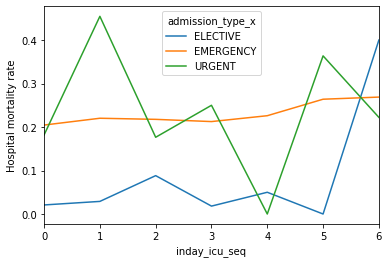

In [0]:
# day_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
ax = dat_dow.plot()
ax.set_ylabel("Hospital mortality rate")

Elective stroke patients indicate patients who have come from the operation theatre.

In [0]:
dat_wkd = data4.groupby(['admission_type_x','inday_icu_wkd'])['hospital_expire_flag_x'].mean().reset_index()
dat_wkd = dat_wkd.pivot(index='inday_icu_wkd', columns='admission_type_x', values='hospital_expire_flag_x')
dat_wkd.head()

admission_type_x,ELECTIVE,EMERGENCY,URGENT
inday_icu_wkd,,,
weekday,0.042857,0.216259,0.228070
weekend,0.181818,0.266504,0.275862


Text(0, 0.5, 'Hospital mortality rate')

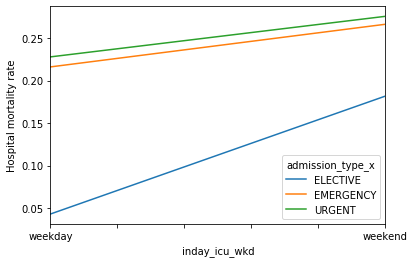

In [0]:
ax = dat_wkd.plot()
ax.set_ylabel("Hospital mortality rate")

##Elective vs Emergency
Grouping Emergency and Urgent together.

In [0]:
# GROUPING EMERGENCY AND URGENT TOGETHER
dat_dow = data4.groupby(['adm_type_2',
                        'inday_icu_seq'])['hospital_expire_flag_x'].mean().reset_index()

dat_dow = dat_dow.pivot(index='inday_icu_seq', 
                        columns='adm_type_2', values='hospital_expire_flag_x')

dat_dow

adm_type_2,elective,emergency
inday_icu_seq,,
0,0.020833,0.204082
1,0.028986,0.225296
2,0.088235,0.216216
3,0.018182,0.213439
4,0.050000,0.223614
5,0.000000,0.266667
6,0.400000,0.266968


Text(0, 0.5, 'Hospital mortality rate')

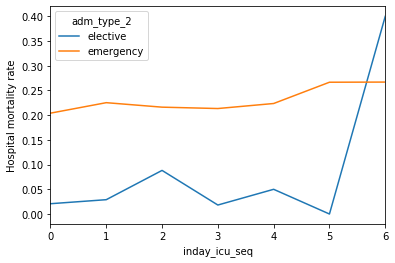

In [0]:
# GROUPING EMERGENCY AND URGENT TOGETHER
# day_map = {0:'Mon', 1:'Tue', 2:'Wed', 3:'Thu', 4:'Fri', 5:'Sat', 6:'Sun'}
ax = dat_dow.plot()
ax.set_ylabel("Hospital mortality rate")

In [0]:
# GROUPING EMERGENCY AND URGENT TOGETHER
dat_wkd = data4.groupby(['adm_type_2','inday_icu_wkd'])['hospital_expire_flag_x'].mean().reset_index()
dat_wkd = dat_wkd.pivot(index='inday_icu_wkd', columns='adm_type_2', values='hospital_expire_flag_x')
dat_wkd.head()

adm_type_2,elective,emergency
inday_icu_wkd,,
weekday,0.042857,0.216519
weekend,0.181818,0.266824


Text(0, 0.5, 'Hospital mortality rate')

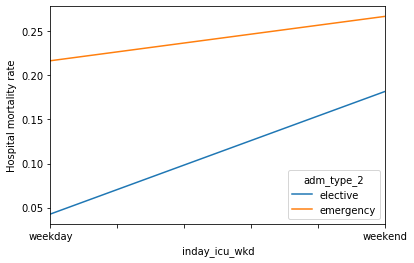

In [0]:
ax = dat_wkd.plot()
ax.set_ylabel("Hospital mortality rate")

##Histograms

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05d11b14a8>]],
      dtype=object)

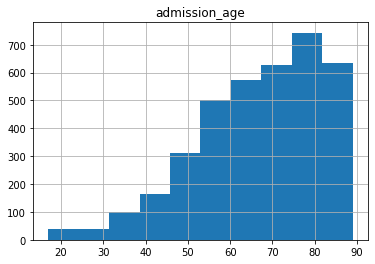

In [0]:
#Histogram of the ages of patients
data4.hist(column='admission_age')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05d116a9e8>]],
      dtype=object)

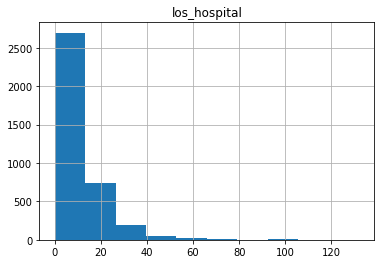

In [0]:
#Histogram of the hospital length of stay
data4.hist(column='los_hospital')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05d1147ba8>]],
      dtype=object)

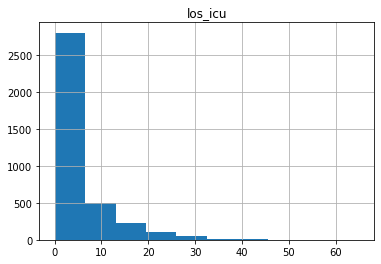

In [0]:
#Histogram of the ICU length of stay
data4.hist(column='los_icu')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05d107e390>]],
      dtype=object)

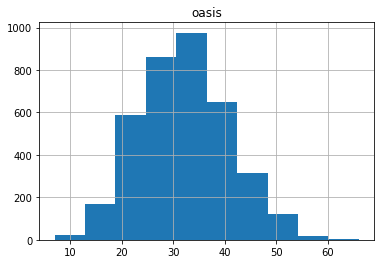

In [0]:
#Histogram of the OASIS scores
data4.hist(column='oasis')

##Heat Map

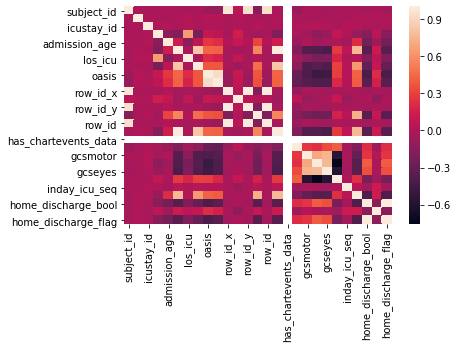

In [0]:
sns.heatmap(data4.corr())
plt.show()

Low values show low intesity of colour and vice versa. This visualises the correlation matrix of data which is useful for feature selection.

#6-Month Mortality

Add a column indicating the number of days that the patient survived post-discharge.

##Inclusive of in-hospital mortality

In [0]:
data4['survival_time'] = data4['dod'].sub(data4['dischtime_hospital'], axis=0)

In [0]:
data4['death_post_discharge_in_days'] = np.where(data4.survival_time.dt.days <= 180, 'short_survival', 'long_survival')

In [0]:
#Turn it into a binary flag
d = {'short_survival': 1, 'long_survival': 0}
data4['survival_time_flag'] = data4['death_post_discharge_in_days'].map(d)

In [0]:
data4.head()

,subject_id,hadm_id,icustay_id,gender_x,admittime_hospital,dischtime_hospital,los_hospital,admission_age,admission_type_x,hospital_expire_flag_x,intime_icu,outtime_icu,los_icu,first_careunit,icustay_expire_flag,oasis,oasis_prob,row_id_x,seq_num,icd9_code,row_id_y,gender_y,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,admittime,dischtime,deathtime,admission_type_y,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag_y,has_chartevents_data,mingcs,gcsmotor,gcsverbal,gcseyes,endotrachflag,admitday_hospital,dischday_hospital,inday_icu,inday_icu_seq,outday_icu,inday_icu_wkd,survival_time,death_post_discharge_in_days,survival_time_flag,home_discharge_bool,adm_type_2,adm_type_2_bool,home_discharge_flag
0,141,168006,234668,M,2140-11-06 11:07:00,2140-11-09 20:36:00,3,80,EMERGENCY,1,2140-11-06 11:09:19,2140-11-09 22:35:29,3.0,MICU,1,53,0.641734,1784.0,2.0,43491,131,M,2060-05-03,2140-11-09,2140-11-09,2140-11-09,1,190,2140-11-06 11:07:00,2140-11-09 20:36:00,2140-11-09 20:36:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,OTHER,SINGLE,OTHER,2140-11-06 07:17:00,2140-11-06 12:07:00,"DRA, SAH",1,1,14.0,6.0,4.0,4.0,0.0,Sunday,Wednesday,Sunday,6,Wednesday,weekend,-1 days +03:24:00,short_survival,1,False,emergency,1,0
1,416,148709,226936,F,2132-07-23 14:46:00,2132-08-11 17:19:00,19,56,EMERGENCY,0,2132-07-23 14:47:03,2132-08-08 17:03:29,16.0,MICU,0,55,0.698023,5023.0,1.0,430,392,F,2076-12-12,2136-11-11,NaT,2136-11-11,1,532,2132-07-23 14:46:00,2132-08-11 17:19:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,HAIT,UNOBTAINABLE,MARRIED,BLACK/AFRICAN AMERICAN,2132-07-23 09:26:00,2132-07-23 15:08:00,SAH,0,1,13.0,6.0,4.0,3.0,0.0,Wednesday,Monday,Wednesday,2,Friday,weekday,1552 days 06:41:00,long_survival,0,True,emergency,1,1
2,490,166850,222952,M,2199-12-12 19:04:00,2199-12-13 20:33:00,1,87,EMERGENCY,1,2199-12-12 21:15:58,2199-12-13 20:33:59,1.0,SICU,1,58,0.772134,5788.0,1.0,43491,463,M,2112-11-20,2199-12-13,2199-12-13,2199-12-13,1,615,2199-12-12 19:04:00,2199-12-13 20:33:00,2199-12-13 20:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,2199-12-12 17:13:00,2199-12-12 22:06:00,CEREBRAL VASCULAR ACCIDENT,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Friday,Thursday,3,Friday,weekday,-1 days +03:27:00,short_survival,1,False,emergency,1,0
3,490,166850,222952,M,2199-12-12 19:04:00,2199-12-13 20:33:00,1,87,EMERGENCY,1,2199-12-12 21:15:58,2199-12-13 20:33:59,1.0,SICU,1,58,0.772134,5789.0,2.0,431,463,M,2112-11-20,2199-12-13,2199-12-13,2199-12-13,1,615,2199-12-12 19:04:00,2199-12-13 20:33:00,2199-12-13 20:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,2199-12-12 17:13:00,2199-12-12 22:06:00,CEREBRAL VASCULAR ACCIDENT,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Friday,Thursday,3,Friday,weekday,-1 days +03:27:00,short_survival,1,False,emergency,1,0
4,831,185983,223445,F,2151-06-30 09:44:00,2151-07-15 13:50:00,15,84,EMERGENCY,0,2151-06-30 09:44:47,2151-07-03 18:15:14,3.0,SICU,0,51,0.581248,9671.0,1.0,431,784,F,2067-05-06,2151-09-10,NaT,2151-09-10,1,1031,2151-06-30 09:44:00,2151-07-15 13:50:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,None,JEWISH,WIDOWED,WHITE,2151-06-30 08:22:00,2151-06-30 11:10:00,STROKE/TIA,0,1,7.0,4.0,1.0,2.0,0.0,Wednesday,Thursday,Wednesday,2,Saturday,weekday,56 days 10:10:00,short_survival,1,False,emergency,1,0


In [0]:
#Patients surviving over the short term (weekday ICU admission)
df_filtered = data4[(data4.inday_icu_wkd == 'weekday') & (data4.death_post_discharge_in_days == 'short_survival')]
df_filtered.shape[0]

865

In [0]:
#Patients surviving over the short term (weekend ICU admission)
df_filtered = data4[(data4.inday_icu_wkd == 'weekend') & (data4.death_post_discharge_in_days == 'short_survival')]
df_filtered.shape[0]

318

In [0]:
#Patients surviving over the long term (weekday ICU admission)
df_filtered = data4[(data4.inday_icu_wkd == 'weekday') & (data4.death_post_discharge_in_days == 'long_survival')]
df_filtered.shape[0]

2006

In [0]:
#Patients surviving over the long term (weekend ICU admission)
df_filtered = data4[(data4.inday_icu_wkd == 'weekend') & (data4.death_post_discharge_in_days == 'long_survival')]
df_filtered.shape[0]

540

## Creation of DF of Survivors
These are patients who were discharged alive.

In [0]:
#Check the type of discharge
data4['discharge_location'].value_counts(dropna=False)

REHAB/DISTINCT PART HOSP     1031
DEAD/EXPIRED                  801
HOME                          662
HOME HEALTH CARE              508
SNF                           384
LONG TERM CARE HOSPITAL       194
SHORT TERM HOSPITAL            60
DISC-TRAN CANCER/CHLDRN H      35
HOSPICE-MEDICAL FACILITY       25
HOSPICE-HOME                   17
LEFT AGAINST MEDICAL ADVI       6
DISCH-TRAN TO PSYCH HOSP        4
HOME WITH HOME IV PROVIDR       1
OTHER FACILITY                  1
Name: discharge_location, dtype: int64

In [0]:
#Create DF of only those who survived
df_survived = data4.where(data4.discharge_location.str.contains('DEAD') == False)
df_survived.discharge_location, data4.discharge_location

(0                            NaN
 1               HOME HEALTH CARE
 2                            NaN
 4       REHAB/DISTINCT PART HOSP
 5                            NaN
                   ...           
 4316            HOME HEALTH CARE
 4318                         NaN
 4319                         NaN
 4320                HOSPICE-HOME
 4321                         NaN
 Name: discharge_location, Length: 3729, dtype: object,
 0                   DEAD/EXPIRED
 1               HOME HEALTH CARE
 2                   DEAD/EXPIRED
 4       REHAB/DISTINCT PART HOSP
 5                   DEAD/EXPIRED
                   ...           
 4316            HOME HEALTH CARE
 4318                DEAD/EXPIRED
 4319                DEAD/EXPIRED
 4320                HOSPICE-HOME
 4321                DEAD/EXPIRED
 Name: discharge_location, Length: 3729, dtype: object)

In [0]:
#Drop the Null values of discharge_location in survivors DF
df_survived = df_survived.dropna(subset=['discharge_location'])
data4.shape, df_survived.shape

((3729, 62), (2928, 62))

The 801 patients (3,720 - 2,928) who were identified as 'DEAD/EXPIRED' have been dropped from the DF. This produces a cohort of 2,928 entries of patients who survived being admitted into the ICU and were discharged.

In [0]:
#Verify resulting DF
df_survived[['dischtime', 'dod','survival_time', 'death_post_discharge_in_days', 'survival_time_flag', 'discharge_location', 'home_discharge_bool', 'inday_icu_wkd']].head()

,dischtime,dod,survival_time,death_post_discharge_in_days,survival_time_flag,discharge_location,home_discharge_bool,inday_icu_wkd
1,2132-08-11 17:19:00,2136-11-11,1552 days 06:41:00,long_survival,0.0,HOME HEALTH CARE,1.0,weekday
4,2151-07-15 13:50:00,2151-09-10,56 days 10:10:00,short_survival,1.0,REHAB/DISTINCT PART HOSP,0.0,weekday
6,2138-03-06 14:00:00,NaT,NaT,long_survival,0.0,HOME,1.0,weekday
9,2191-05-12 15:00:00,2191-05-13,0 days 09:00:00,short_survival,1.0,SNF,0.0,weekday
11,2150-11-30 18:14:00,NaT,NaT,long_survival,0.0,HOME,1.0,weekday


##Exclusive of in-hospital mortality

In [0]:
#Patients surviving over the short term (weekday ICU admission)
df_filtered = df_survived[(df_survived.inday_icu_wkd == 'weekday') & (df_survived.death_post_discharge_in_days == 'short_survival')]
df_filtered.shape[0]

292

In [0]:
#Patients surviving over the short term (weekend ICU admission)
df_filtered = df_survived[(df_survived.inday_icu_wkd == 'weekend') & (df_survived.death_post_discharge_in_days == 'short_survival')]
df_filtered.shape[0]

90

In [0]:
#Patients surviving over the long term (weekday ICU admission)
df_filtered = df_survived[(df_survived.inday_icu_wkd == 'weekday') & (df_survived.death_post_discharge_in_days == 'long_survival')]
df_filtered.shape[0]

2006

In [0]:
#Patients surviving over the long term (weekend ICU admission)
df_filtered = df_survived[(df_survived.inday_icu_wkd == 'weekend') & (df_survived.death_post_discharge_in_days == 'long_survival')]
df_filtered.shape[0]

540

In [0]:
#FOR DF_SURVIVED DATABASE
columns = ['gender_x', 'los_hospital', 'admission_age', 'admission_type_x', 'hospital_expire_flag_x', 
           'los_icu','icustay_expire_flag', 'oasis', 'oasis_prob', 'first_careunit', 'death_post_discharge_in_days']

groupby = 'inday_icu_wkd'

pval = False

categorical = ['gender_x','admission_type_x','hospital_expire_flag_x','icustay_expire_flag',
               'first_careunit', 'death_post_discharge_in_days']

t = TableOne(df_survived, columns=columns, categorical=categorical, groupby=groupby, pval=pval)
t.tableone

Grouped by inday_icu_wkd  ...             
                                                             Missing  ...      weekend
n                                                                     ...          630
gender_x                     F                                     0  ...   278 (44.1)
                             M                                        ...   352 (55.9)
los_hospital                                                       0  ...  12.8 (11.8)
admission_age                                                      0  ...  64.1 (15.6)
admission_type_x             ELECTIVE                              0  ...      9 (1.4)
                             EMERGENCY                                ...   600 (95.2)
                             URGENT                                   ...     21 (3.3)
hospital_expire_flag_x       0.0                                   0  ...  630 (100.0)
los_icu                                                            0  ...    6.1 (7.1)
icustay_expire_flag          0.0                                   0  ...  630 (100.0)
oasis                                                              0  ...   30.2 (7.7)
oasis_prob                                                         0  ...    0.1 (0.1)
first_careunit               CCU                                   0  ...     41 (6.5)
                             CSRU                                     ...     31 (4.9)
                             MICU                                     ...   109 (17.3)
                             SICU                                     ...   334 (53.0)
                             TSICU                                    ...   115 (18.3)
death_post_discharge_in_days long_survival                         0  ...   540 (85.7)
                             short_survival                           ...    90 (14.3)

[20 rows x 3 columns]

#Adding Ethnicity, Marital Status and Insurance Status

##Ethnicity

In [0]:
data4['ethnicity'].value_counts(dropna=False)

WHITE                                        2705
UNKNOWN/NOT SPECIFIED                         310
BLACK/AFRICAN AMERICAN                        241
HISPANIC OR LATINO                            100
OTHER                                          99
UNABLE TO OBTAIN                               70
ASIAN                                          67
PATIENT DECLINED TO ANSWER                     23
HISPANIC/LATINO - PUERTO RICAN                 14
HISPANIC/LATINO - DOMINICAN                    13
ASIAN - CHINESE                                12
BLACK/CAPE VERDEAN                              8
MULTI RACE ETHNICITY                            8
WHITE - RUSSIAN                                 7
WHITE - BRAZILIAN                               6
BLACK/HAITIAN                                   6
WHITE - OTHER EUROPEAN                          5
PORTUGUESE                                      5
ASIAN - ASIAN INDIAN                            4
MIDDLE EASTERN                                  3


Ethnicity will be categorised into BLACK, WHITE, OTHER and UNKNOWN. Run the code in the following box using the appropriate terminology.

In [0]:
#Calculating number of patients categorised as 'black' and admitted in the weekday
df_filtered = data4[(data4.inday_icu_wkd == 'weekday') & (data4.ethnicity.str.contains('^BLACK'))]
df_filtered.shape[0]

196

In [0]:
#Here, calculating number of patients categorised as 'black' and admitted in the weekend
df_filtered = data4[(data4.inday_icu_wkd == 'weekend') & (data4.ethnicity.str.contains('^BLACK'))]
df_filtered.shape[0]

65

In [0]:
#Investigate stats
#Here, calculating number of patients categorised as 'white' and admitted in the weekday
df_filtered = data4[(data4.inday_icu_wkd == 'weekday') & (data4.ethnicity =='WHITE')]
df_filtered.shape[0]

2094

In [0]:
#Investigate stats
#Here, calculating number of patients categorised as 'white' and admitted in the weekend
df_filtered = data4[(data4.inday_icu_wkd == 'weekend') & (data4.ethnicity =='WHITE')]
df_filtered.shape[0]

611

In [0]:
#Calculating number of patients categorised as 'unknown' and admitted in the weekday
df_filtered = data4[(data4.inday_icu_wkd == 'weekday') & (data4.ethnicity.str.contains('^UNKNOWN'))]
df_filtered.shape[0]

234

In [0]:
#Calculating number of patients categorised as 'unknown' and admitted in the weekend
df_filtered = data4[(data4.inday_icu_wkd == 'weekend') & (data4.ethnicity.str.contains('^UNKNOWN'))]
df_filtered.shape[0]

76

In [0]:
#Check total number of admissions into the ICU in weekdays vs weekends
data4['inday_icu_wkd'].value_counts(dropna=False)

weekday    2871
weekend     858
Name: inday_icu_wkd, dtype: int64

In [0]:
#Other ethnicities who were admitted in the weekday
2871 - 196 - 2094 - 234

347

In [0]:
#Other ethnicities who were admitted in the weekday
858 - 65 - 611 - 76

106

##Marital Status

In [0]:
data4['marital_status'].value_counts(dropna=False)

MARRIED              1944
SINGLE                728
WIDOWED               502
NaN                   288
DIVORCED              207
UNKNOWN (DEFAULT)      35
SEPARATED              24
LIFE PARTNER            1
Name: marital_status, dtype: int64

In [0]:
#Weekday - Married
df_filtered = data4[(data4.inday_icu_wkd == 'weekday') & (data4.marital_status == 'MARRIED')]
df_filtered.shape[0]

1503

In [0]:
#Weekend - Married
df_filtered = data4[(data4.inday_icu_wkd == 'weekend') & (data4.marital_status == 'MARRIED')]
df_filtered.shape[0]

441

##Insurance

In [0]:
data4['insurance'].value_counts(dropna=False)

Medicare      2138
Private       1178
Medicaid       269
Government      93
Self Pay        51
Name: insurance, dtype: int64

In [0]:
#Medicaid in the weekday
df_filtered = data4[(data4.inday_icu_wkd == 'weekday') & (data4.insurance == 'Medicaid')]
df_filtered.shape[0]

195

In [0]:
#Medicaid in the weekend
df_filtered = data4[(data4.inday_icu_wkd == 'weekend') & (data4.insurance == 'Medicaid')]
df_filtered.shape[0]

74

In [0]:
#Medicare in the weekday
df_filtered = data4[(data4.inday_icu_wkd == 'weekday') & (data4.insurance == 'Medicare')]
df_filtered.shape[0]

1684

In [0]:
#Medicare in the weekend
df_filtered = data4[(data4.inday_icu_wkd == 'weekend') & (data4.insurance == 'Medicare')]
df_filtered.shape[0]

454

#GCS Values

In [0]:
data4['mingcs'].value_counts(dropna=False)

15.0    1862
14.0     619
13.0     254
3.0      145
12.0     134
11.0     124
10.0     118
7.0      103
9.0       95
6.0       92
8.0       90
4.0       34
NaN       31
5.0       28
Name: mingcs, dtype: int64

These are the standards prescribed by the British Medical Journal.

Mild -> GCS 13-15

Moderate -> GCS 9-12

Severe -> GCS 3-8

In [0]:
columns = ['gender_x', 'los_hospital', 'admission_age', 'admission_type_x', 'hospital_expire_flag_x', 
           'los_icu','icustay_expire_flag', 'oasis', 'oasis_prob', 'first_careunit', 'mingcs', 'death_post_discharge_in_days', 'insurance']

groupby = 'inday_icu_wkd'

pval = False

categorical = ['gender_x','admission_type_x','hospital_expire_flag_x','icustay_expire_flag',
               'first_careunit', 'death_post_discharge_in_days', 'insurance']

t = TableOne(data4, columns=columns, categorical=categorical, groupby=groupby, pval=pval)
t.tableone

Grouped by inday_icu_wkd  ...             
                                                             Missing  ...      weekend
n                                                                     ...          858
gender_x                     F                                     0  ...   380 (44.3)
                             M                                        ...   478 (55.7)
los_hospital                                                       0  ...  11.2 (11.6)
admission_age                                                      0  ...  65.4 (15.6)
admission_type_x             ELECTIVE                              0  ...     11 (1.3)
                             EMERGENCY                                ...   818 (95.3)
                             URGENT                                   ...     29 (3.4)
hospital_expire_flag_x       0                                     0  ...   630 (73.4)
                             1                                        ...   228 (26.6)
los_icu                                                            0  ...    5.6 (6.7)
icustay_expire_flag          0                                     0  ...   697 (81.2)
                             1                                        ...   161 (18.8)
oasis                                                              0  ...   32.5 (8.7)
oasis_prob                                                         0  ...    0.2 (0.1)
first_careunit               CCU                                   0  ...     54 (6.3)
                             CSRU                                     ...     38 (4.4)
                             MICU                                     ...   167 (19.5)
                             SICU                                     ...   449 (52.3)
                             TSICU                                    ...   150 (17.5)
mingcs                                                            31  ...   12.6 (3.4)
death_post_discharge_in_days long_survival                         0  ...   540 (62.9)
                             short_survival                           ...   318 (37.1)
insurance                    Government                            0  ...     25 (2.9)
                             Medicaid                                 ...     74 (8.6)
                             Medicare                                 ...   454 (52.9)
                             Private                                  ...   288 (33.6)
                             Self Pay                                 ...     17 (2.0)

[28 rows x 3 columns]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f05d0ce4be0>]],
      dtype=object)

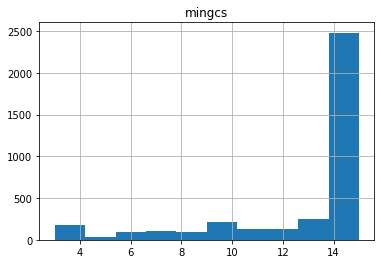

In [0]:
#Histogram of the minimum GCS scores
data4.hist(column='mingcs')

#Discharge Destination

##Inclusive of in-house mortality

In [0]:
data4['discharge_location'].value_counts(dropna=False)

REHAB/DISTINCT PART HOSP     1031
DEAD/EXPIRED                  801
HOME                          662
HOME HEALTH CARE              508
SNF                           384
LONG TERM CARE HOSPITAL       194
SHORT TERM HOSPITAL            60
DISC-TRAN CANCER/CHLDRN H      35
HOSPICE-MEDICAL FACILITY       25
HOSPICE-HOME                   17
LEFT AGAINST MEDICAL ADVI       6
DISCH-TRAN TO PSYCH HOSP        4
HOME WITH HOME IV PROVIDR       1
OTHER FACILITY                  1
Name: discharge_location, dtype: int64

In [0]:
#Identify all 'home' categories
home = ['HOME', 'HOME HEALTH CARE', 'HOME WITH HOME IV PROVIDR']
# The remaining are classified as 'other'

In [0]:
#Create a binary column with all 'home' categories as 1
data4['home_discharge_bool'] = data4.discharge_location.str.contains('^HOME')
data4.columns

Index(['subject_id', 'hadm_id', 'icustay_id', 'gender_x', 'admittime_hospital',
       'dischtime_hospital', 'los_hospital', 'admission_age',
       'admission_type_x', 'hospital_expire_flag_x', 'intime_icu',
       'outtime_icu', 'los_icu', 'first_careunit', 'icustay_expire_flag',
       'oasis', 'oasis_prob', 'row_id_x', 'seq_num', 'icd9_code', 'row_id_y',
       'gender_y', 'dob', 'dod', 'dod_hosp', 'dod_ssn', 'expire_flag',
       'row_id', 'admittime', 'dischtime', 'deathtime', 'admission_type_y',
       'admission_location', 'discharge_location', 'insurance', 'language',
       'religion', 'marital_status', 'ethnicity', 'edregtime', 'edouttime',
       'diagnosis', 'hospital_expire_flag_y', 'has_chartevents_data', 'mingcs',
       'gcsmotor', 'gcsverbal', 'gcseyes', 'endotrachflag',
       'admitday_hospital', 'dischday_hospital', 'inday_icu', 'inday_icu_seq',
       'outday_icu', 'inday_icu_wkd', 'survival_time',
       'death_post_discharge_in_days', 'survival_time_flag',
     

In [0]:
data4.head(20)

,subject_id,hadm_id,icustay_id,gender_x,admittime_hospital,dischtime_hospital,los_hospital,admission_age,admission_type_x,hospital_expire_flag_x,intime_icu,outtime_icu,los_icu,first_careunit,icustay_expire_flag,oasis,oasis_prob,row_id_x,seq_num,icd9_code,row_id_y,gender_y,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,admittime,dischtime,deathtime,admission_type_y,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag_y,has_chartevents_data,mingcs,gcsmotor,gcsverbal,gcseyes,endotrachflag,admitday_hospital,dischday_hospital,inday_icu,inday_icu_seq,outday_icu,inday_icu_wkd,survival_time,death_post_discharge_in_days,survival_time_flag,home_discharge_bool,adm_type_2,adm_type_2_bool,home_discharge_flag
0,141,168006,234668,M,2140-11-06 11:07:00,2140-11-09 20:36:00,3,80,EMERGENCY,1,2140-11-06 11:09:19,2140-11-09 22:35:29,3.0,MICU,1,53,0.641734,1784.0,2.0,43491,131,M,2060-05-03,2140-11-09,2140-11-09,2140-11-09,1,190,2140-11-06 11:07:00,2140-11-09 20:36:00,2140-11-09 20:36:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,OTHER,SINGLE,OTHER,2140-11-06 07:17:00,2140-11-06 12:07:00,"DRA, SAH",1,1,14.0,6.0,4.0,4.0,0.0,Sunday,Wednesday,Sunday,6,Wednesday,weekend,-1 days +03:24:00,short_survival,1,False,emergency,1,0
1,416,148709,226936,F,2132-07-23 14:46:00,2132-08-11 17:19:00,19,56,EMERGENCY,0,2132-07-23 14:47:03,2132-08-08 17:03:29,16.0,MICU,0,55,0.698023,5023.0,1.0,430,392,F,2076-12-12,2136-11-11,NaT,2136-11-11,1,532,2132-07-23 14:46:00,2132-08-11 17:19:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,HAIT,UNOBTAINABLE,MARRIED,BLACK/AFRICAN AMERICAN,2132-07-23 09:26:00,2132-07-23 15:08:00,SAH,0,1,13.0,6.0,4.0,3.0,0.0,Wednesday,Monday,Wednesday,2,Friday,weekday,1552 days 06:41:00,long_survival,0,True,emergency,1,1
2,490,166850,222952,M,2199-12-12 19:04:00,2199-12-13 20:33:00,1,87,EMERGENCY,1,2199-12-12 21:15:58,2199-12-13 20:33:59,1.0,SICU,1,58,0.772134,5788.0,1.0,43491,463,M,2112-11-20,2199-12-13,2199-12-13,2199-12-13,1,615,2199-12-12 19:04:00,2199-12-13 20:33:00,2199-12-13 20:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,2199-12-12 17:13:00,2199-12-12 22:06:00,CEREBRAL VASCULAR ACCIDENT,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Friday,Thursday,3,Friday,weekday,-1 days +03:27:00,short_survival,1,False,emergency,1,0
4,831,185983,223445,F,2151-06-30 09:44:00,2151-07-15 13:50:00,15,84,EMERGENCY,0,2151-06-30 09:44:47,2151-07-03 18:15:14,3.0,SICU,0,51,0.581248,9671.0,1.0,431,784,F,2067-05-06,2151-09-10,NaT,2151-09-10,1,1031,2151-06-30 09:44:00,2151-07-15 13:50:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,None,JEWISH,WIDOWED,WHITE,2151-06-30 08:22:00,2151-06-30 11:10:00,STROKE/TIA,0,1,7.0,4.0,1.0,2.0,0.0,Wednesday,Thursday,Wednesday,2,Saturday,weekday,56 days 10:10:00,short_survival,1,False,emergency,1,0
5,1054,183383,288218,M,2157-01-06 17:16:00,2157-01-08 15:00:00,2,79,EMERGENCY,1,2157-01-06 17:17:38,2157-01-07 22:01:06,1.0,SICU,0,51,0.581248,12291.0,1.0,430,998,M,2078-07-15,2157-01-08,2157-01-08,NaT,1,1310,2157-01-06 17:16:00,2157-01-08 15:00:00,2157-01-08 15:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,PROTESTANT QUAKER,MARRIED,WHITE,2157-01-06 14:49:00,2157-01-06 18:36:00,INTRACRANIAL HEMORRHAGE,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Saturday,Thursday,3,Friday,weekday,-1 days +09:00:00,short_survival,1,False,emergency,1,0
6,1253,129963,246324,F,2138-02-25 07:15:00,2138-03-06 14:00:00,9,58,ELECTIVE,0,2138-02-25 14:45:22,2138-02-26 21:39:17,1.0,SICU,0,13,0.010803,14362.0,3.0,431,1189,F,2080-11-28,NaT,NaT,NaT,0,1543,2138-02-25 07:15:00,2138-03-06 14:00:00,NaT,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME,Private,None,JEWISH,MARRIED,WHITE,NaT,NaT,ANEURYSM/SDA,0,1,15.0,6.0,5.0,4.0,0.0,Tuesday,Thursday,Tuesday,1,Wednesday,weekday,NaT,long_survival,0,True,elective,0,1
7,1381,181430,291798,F,2189-01-02 14:25:00,2189-01-02 12:00:00,0,82,EMERGENCY,1,2189-01-02 14:28:39,

In [0]:
#True=discharged for home - Weekday
df_filtered = data4[(data4.inday_icu_wkd == 'weekday') & (data4.home_discharge_bool == True)] 
df_filtered.shape[0]

937

In [0]:
#False=discharged for home - Weekend
df_filtered = data4[(data4.inday_icu_wkd == 'weekend') & (data4.home_discharge_bool == True)] 
df_filtered.shape[0]

234

In [0]:
#True=discharged for other facilities - Weekday
df_filtered = data4[(data4.inday_icu_wkd == 'weekday') & (data4.home_discharge_bool == False)] 
df_filtered.shape[0]

1934

In [0]:
#True=discharged for other facilities - Weekend
df_filtered = data4[(data4.inday_icu_wkd == 'weekend') & (data4.home_discharge_bool == False)] 
df_filtered.shape[0]

624

In [0]:
#NOT REQUIRED YET - IT WILL BE RUN LATER
#Excluding age>300
#For ICU mortality adjusting for admission type, age and sex
adj_glm = smf.glm('home_discharge_bool ~ C(inday_icu_wkd) + C(admission_type_x) + admission_age +C(gender_x)', 
                     data=data4, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Generalized linear model
===========================================================================================================
Model:              GLM                                                         AIC:            4352.4461  
Link Function:      logit                                                       BIC:            -26277.1164
Dependent Variable: ['home_discharge_bool[False]', 'home_discharge_bool[True]'] Log-Likelihood: -2170.2    
Date:               2020-01-22 06:08                                            LL-Null:        -2320.5    
No. Observations:   3729                                                        Deviance:       4340.4     
Df Model:           5                                                           Pearson chi2:   3.69e+03   
Df Residuals:       3723                                                        Scale:          1.0000     
Method:             IRLS                                                                                   
----------------------------------------------------------------------------------------------------------------
                                        Coef.       Std.Err.         z          P>|z|        [0.025       0.975]
----------------------------------------------------------------------------------------------------------------
Intercept                              -2.6997        0.2205      -12.2420      0.0000      -3.1319      -2.2675
C(inday_icu_wkd)[T.weekend]             0.2417        0.0909        2.6598      0.0078       0.0636       0.4199
C(admission_type_x)[T.EMERGENCY]        1.2104        0.1284        9.4257      0.0000       0.9587       1.4621
C(admission_type_x)[T.URGENT]           0.8878        0.2625        3.3827      0.0007       0.3734       1.4023
C(gender_x)[T.M]                       -0.0755        0.0742       -1.0169      0.3092      -0.2210       0.0700
admission_age                           0.0362        0.0025       14.4137      0.0000       0.0313       0.0411
===========================================================================================================

"""

##Exclusive of in-house mortality
The statistics of only those who were discharged alive

In [0]:
#Verify resulting DF
df_survived[['discharge_location', 'home_discharge_bool', 'inday_icu_wkd']].head()

,discharge_location,home_discharge_bool,inday_icu_wkd
1,HOME HEALTH CARE,1.0,weekday
4,REHAB/DISTINCT PART HOSP,0.0,weekday
6,HOME,1.0,weekday
9,SNF,0.0,weekday
11,HOME,1.0,weekday


###Summary

In [0]:
#Surviving patients discharged for home (weekday ICU admission)
df_filtered = df_survived[(df_survived.inday_icu_wkd == 'weekday') & (df_survived.home_discharge_bool == True)] 
df_filtered.shape[0]

937

In [0]:
#Surviving patients discharged for home (weekend ICU admission)
df_filtered = df_survived[(df_survived.inday_icu_wkd == 'weekend') & (df_survived.home_discharge_bool == True)] 
df_filtered.shape[0]

234

In [0]:
#Surviving patients discharged for other facilities (weekday ICU admission)
df_filtered = df_survived[(df_survived.inday_icu_wkd == 'weekday') & (df_survived.home_discharge_bool == False)] 
df_filtered.shape[0]

1361

In [0]:
#Surviving patients discharged for other facilities (weekend ICU admission)
df_filtered = df_survived[(df_survived.inday_icu_wkd == 'weekend') & (df_survived.home_discharge_bool == False)] 
df_filtered.shape[0]

396

In [0]:
#FOR DF_SURVIVED DATABASE
columns = ['gender_x', 'los_hospital', 'admission_age', 'admission_type_x', 'hospital_expire_flag_x', 
           'los_icu','icustay_expire_flag', 'oasis', 'oasis_prob', 'first_careunit', 'death_post_discharge_in_days', 'home_discharge_bool']

groupby = 'inday_icu_wkd'

pval = False

categorical = ['gender_x','admission_type_x','hospital_expire_flag_x','icustay_expire_flag',
               'first_careunit', 'death_post_discharge_in_days', 'home_discharge_bool']

t = TableOne(df_survived, columns=columns, categorical=categorical, groupby=groupby, pval=pval)
t.tableone

Grouped by inday_icu_wkd  ...             
                                                             Missing  ...      weekend
n                                                                     ...          630
gender_x                     F                                     0  ...   278 (44.1)
                             M                                        ...   352 (55.9)
los_hospital                                                       0  ...  12.8 (11.8)
admission_age                                                      0  ...  64.1 (15.6)
admission_type_x             ELECTIVE                              0  ...      9 (1.4)
                             EMERGENCY                                ...   600 (95.2)
                             URGENT                                   ...     21 (3.3)
hospital_expire_flag_x       0.0                                   0  ...  630 (100.0)
los_icu                                                            0  ...    6.1 (7.1)
icustay_expire_flag          0.0                                   0  ...  630 (100.0)
oasis                                                              0  ...   30.2 (7.7)
oasis_prob                                                         0  ...    0.1 (0.1)
first_careunit               CCU                                   0  ...     41 (6.5)
                             CSRU                                     ...     31 (4.9)
                             MICU                                     ...   109 (17.3)
                             SICU                                     ...   334 (53.0)
                             TSICU                                    ...   115 (18.3)
death_post_discharge_in_days long_survival                         0  ...   540 (85.7)
                             short_survival                           ...    90 (14.3)
home_discharge_bool          0.0                                   0  ...   396 (62.9)
                             1.0                                      ...   234 (37.1)

[22 rows x 3 columns]

#Grouping Emergency and Urgent into a single category called 'emergency'

In [0]:
data4['admission_type_x'].value_counts(dropna=False)

EMERGENCY    3352
ELECTIVE      291
URGENT         86
Name: admission_type_x, dtype: int64

In [0]:
#admission_type_x
data4.admission_type_x.str.contains('EMERGENCY')

0       True
1       True
2       True
4       True
5       True
        ... 
4316    True
4318    True
4319    True
4320    True
4321    True
Name: admission_type_x, Length: 3729, dtype: bool

In [0]:
data4['adm_type_2'] = np.where(data4.admission_type_x == 'ELECTIVE', 'elective', 'emergency')
data4.head(20)

,subject_id,hadm_id,icustay_id,gender_x,admittime_hospital,dischtime_hospital,los_hospital,admission_age,admission_type_x,hospital_expire_flag_x,intime_icu,outtime_icu,los_icu,first_careunit,icustay_expire_flag,oasis,oasis_prob,row_id_x,seq_num,icd9_code,row_id_y,gender_y,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,admittime,dischtime,deathtime,admission_type_y,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag_y,has_chartevents_data,mingcs,gcsmotor,gcsverbal,gcseyes,endotrachflag,admitday_hospital,dischday_hospital,inday_icu,inday_icu_seq,outday_icu,inday_icu_wkd,survival_time,death_post_discharge_in_days,survival_time_flag,home_discharge_bool,adm_type_2
0,141,168006,234668,M,2140-11-06 11:07:00,2140-11-09 20:36:00,3,80,EMERGENCY,1,2140-11-06 11:09:19,2140-11-09 22:35:29,3.0,MICU,1,53,0.641734,1784.0,2.0,43491,131,M,2060-05-03,2140-11-09,2140-11-09,2140-11-09,1,190,2140-11-06 11:07:00,2140-11-09 20:36:00,2140-11-09 20:36:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,OTHER,SINGLE,OTHER,2140-11-06 07:17:00,2140-11-06 12:07:00,"DRA, SAH",1,1,14.0,6.0,4.0,4.0,0.0,Sunday,Wednesday,Sunday,6,Wednesday,weekend,-1 days +03:24:00,short_survival,1,False,emergency
1,416,148709,226936,F,2132-07-23 14:46:00,2132-08-11 17:19:00,19,56,EMERGENCY,0,2132-07-23 14:47:03,2132-08-08 17:03:29,16.0,MICU,0,55,0.698023,5023.0,1.0,430,392,F,2076-12-12,2136-11-11,NaT,2136-11-11,1,532,2132-07-23 14:46:00,2132-08-11 17:19:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,HAIT,UNOBTAINABLE,MARRIED,BLACK/AFRICAN AMERICAN,2132-07-23 09:26:00,2132-07-23 15:08:00,SAH,0,1,13.0,6.0,4.0,3.0,0.0,Wednesday,Monday,Wednesday,2,Friday,weekday,1552 days 06:41:00,long_survival,0,True,emergency
2,490,166850,222952,M,2199-12-12 19:04:00,2199-12-13 20:33:00,1,87,EMERGENCY,1,2199-12-12 21:15:58,2199-12-13 20:33:59,1.0,SICU,1,58,0.772134,5788.0,1.0,43491,463,M,2112-11-20,2199-12-13,2199-12-13,2199-12-13,1,615,2199-12-12 19:04:00,2199-12-13 20:33:00,2199-12-13 20:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,2199-12-12 17:13:00,2199-12-12 22:06:00,CEREBRAL VASCULAR ACCIDENT,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Friday,Thursday,3,Friday,weekday,-1 days +03:27:00,short_survival,1,False,emergency
3,490,166850,222952,M,2199-12-12 19:04:00,2199-12-13 20:33:00,1,87,EMERGENCY,1,2199-12-12 21:15:58,2199-12-13 20:33:59,1.0,SICU,1,58,0.772134,5789.0,2.0,431,463,M,2112-11-20,2199-12-13,2199-12-13,2199-12-13,1,615,2199-12-12 19:04:00,2199-12-13 20:33:00,2199-12-13 20:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,2199-12-12 17:13:00,2199-12-12 22:06:00,CEREBRAL VASCULAR ACCIDENT,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Friday,Thursday,3,Friday,weekday,-1 days +03:27:00,short_survival,1,False,emergency
4,831,185983,223445,F,2151-06-30 09:44:00,2151-07-15 13:50:00,15,84,EMERGENCY,0,2151-06-30 09:44:47,2151-07-03 18:15:14,3.0,SICU,0,51,0.581248,9671.0,1.0,431,784,F,2067-05-06,2151-09-10,NaT,2151-09-10,1,1031,2151-06-30 09:44:00,2151-07-15 13:50:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,None,JEWISH,WIDOWED,WHITE,2151-06-30 08:22:00,2151-06-30 11:10:00,STROKE/TIA,0,1,7.0,4.0,1.0,2.0,0.0,Wednesday,Thursday,Wednesday,2,Saturday,weekday,56 days 10:10:00,short_survival,1,False,emergency
5,1054,183383,288218,M,2157-01-06 17:16:00,2157-01-08 15:00:00,2,79,EMERGENCY,1,2157-01-06 17:17:38,2157-01-07 22:01:06,1.0,SICU,0,51,0.581248,12291.0,1.0,430,998,M,2078-07-15,2157-01-08,2157-01-08,NaT,1,1310,2157-01-06 17:16:00,2157-01-08 15:00:00,2157-01-08 15:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,PROTESTANT QUAKER,MARRIED,WHITE,2157-01-06 14:49:00,2157-01-06 18:36:00,INTRACRANIAL HEMORRHAGE,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Saturday,Thursday,3,Friday,weekday,-1 days +09:00:00,short_survival,1,False,emergency
6,1253,129963,246324,F,2138-02-25 07:15:00,2138-03-06 14

In [0]:
#Emergency - Weekday
df_filtered = data4[(data4.inday_icu_wkd == 'weekday') & (data4.adm_type_2 == 'emergency')] 
df_filtered.shape[0]

2591

In [0]:
#Emergency - Weekend
df_filtered = data4[(data4.inday_icu_wkd == 'weekend') & (data4.adm_type_2 == 'emergency')] 
df_filtered.shape[0]

847

In [0]:
#Change 'adm_type_2' to boolean to run the model and predict on emergency
#Create a binary column with all 'home' categories as 1
data4['adm_type_2_bool'] = np.where(data4.adm_type_2 == 'emergency', 1, 0)

In [0]:
#home_discharge_bool
data4['home_discharge_flag'] = np.where(data4.home_discharge_bool == True, 1, 0)

In [0]:
#FOR THE FULL DATAFRAME
columns = ['gender_x', 'los_hospital', 'admission_age', 'admission_type_x', 'hospital_expire_flag_x', 
           'los_icu','icustay_expire_flag', 'oasis', 'oasis_prob', 'first_careunit', 'mingcs', 'death_post_discharge_in_days', 'insurance', 'adm_type_2']

groupby = 'inday_icu_wkd'

pval = False

categorical = ['gender_x','admission_type_x','hospital_expire_flag_x','icustay_expire_flag',
               'first_careunit', 'death_post_discharge_in_days', 'insurance', 'adm_type_2']

t = TableOne(data4, columns=columns, categorical=categorical, groupby=groupby, pval=pval)
t.tableone

Grouped by inday_icu_wkd  ...             
                                                             Missing  ...      weekend
n                                                                     ...          858
gender_x                     F                                     0  ...   380 (44.3)
                             M                                        ...   478 (55.7)
los_hospital                                                       0  ...  11.2 (11.6)
admission_age                                                      0  ...  65.4 (15.6)
admission_type_x             ELECTIVE                              0  ...     11 (1.3)
                             EMERGENCY                                ...   818 (95.3)
                             URGENT                                   ...     29 (3.4)
hospital_expire_flag_x       0                                     0  ...   630 (73.4)
                             1                                        ...   228 (26.6)
los_icu                                                            0  ...    5.6 (6.7)
icustay_expire_flag          0                                     0  ...   697 (81.2)
                             1                                        ...   161 (18.8)
oasis                                                              0  ...   32.5 (8.7)
oasis_prob                                                         0  ...    0.2 (0.1)
first_careunit               CCU                                   0  ...     54 (6.3)
                             CSRU                                     ...     38 (4.4)
                             MICU                                     ...   167 (19.5)
                             SICU                                     ...   449 (52.3)
                             TSICU                                    ...   150 (17.5)
mingcs                                                            31  ...   12.6 (3.4)
death_post_discharge_in_days long_survival                         0  ...   540 (62.9)
                             short_survival                           ...   318 (37.1)
insurance                    Government                            0  ...     25 (2.9)
                             Medicaid                                 ...     74 (8.6)
                             Medicare                                 ...   454 (52.9)
                             Private                                  ...   288 (33.6)
                             Self Pay                                 ...     17 (2.0)
adm_type_2                   elective                              0  ...     11 (1.3)
                             emergency                                ...   847 (98.7)

[30 rows x 3 columns]

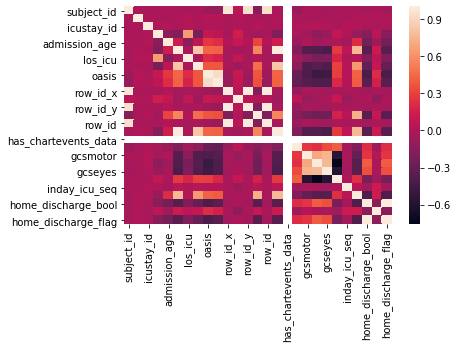

In [0]:
sns.heatmap(data4.corr())
plt.show()

#Statistical Analysis: T-Test

In [0]:
data4.head()

,subject_id,hadm_id,icustay_id,gender_x,admittime_hospital,dischtime_hospital,los_hospital,admission_age,admission_type_x,hospital_expire_flag_x,intime_icu,outtime_icu,los_icu,first_careunit,icustay_expire_flag,oasis,oasis_prob,row_id_x,seq_num,icd9_code,row_id_y,gender_y,dob,dod,dod_hosp,dod_ssn,expire_flag,row_id,admittime,dischtime,deathtime,admission_type_y,admission_location,discharge_location,insurance,language,religion,marital_status,ethnicity,edregtime,edouttime,diagnosis,hospital_expire_flag_y,has_chartevents_data,mingcs,gcsmotor,gcsverbal,gcseyes,endotrachflag,admitday_hospital,dischday_hospital,inday_icu,inday_icu_seq,outday_icu,inday_icu_wkd,survival_time,death_post_discharge_in_days,survival_time_flag,home_discharge_bool,adm_type_2,adm_type_2_bool,home_discharge_flag
0,141,168006,234668,M,2140-11-06 11:07:00,2140-11-09 20:36:00,3,80,EMERGENCY,1,2140-11-06 11:09:19,2140-11-09 22:35:29,3.0,MICU,1,53,0.641734,1784.0,2.0,43491,131,M,2060-05-03,2140-11-09,2140-11-09,2140-11-09,1,190,2140-11-06 11:07:00,2140-11-09 20:36:00,2140-11-09 20:36:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,OTHER,SINGLE,OTHER,2140-11-06 07:17:00,2140-11-06 12:07:00,"DRA, SAH",1,1,14.0,6.0,4.0,4.0,0.0,Sunday,Wednesday,Sunday,6,Wednesday,weekend,-1 days +03:24:00,short_survival,1,False,emergency,1,0
1,416,148709,226936,F,2132-07-23 14:46:00,2132-08-11 17:19:00,19,56,EMERGENCY,0,2132-07-23 14:47:03,2132-08-08 17:03:29,16.0,MICU,0,55,0.698023,5023.0,1.0,430,392,F,2076-12-12,2136-11-11,NaT,2136-11-11,1,532,2132-07-23 14:46:00,2132-08-11 17:19:00,NaT,EMERGENCY,EMERGENCY ROOM ADMIT,HOME HEALTH CARE,Medicaid,HAIT,UNOBTAINABLE,MARRIED,BLACK/AFRICAN AMERICAN,2132-07-23 09:26:00,2132-07-23 15:08:00,SAH,0,1,13.0,6.0,4.0,3.0,0.0,Wednesday,Monday,Wednesday,2,Friday,weekday,1552 days 06:41:00,long_survival,0,True,emergency,1,1
2,490,166850,222952,M,2199-12-12 19:04:00,2199-12-13 20:33:00,1,87,EMERGENCY,1,2199-12-12 21:15:58,2199-12-13 20:33:59,1.0,SICU,1,58,0.772134,5788.0,1.0,43491,463,M,2112-11-20,2199-12-13,2199-12-13,2199-12-13,1,615,2199-12-12 19:04:00,2199-12-13 20:33:00,2199-12-13 20:33:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,UNOBTAINABLE,MARRIED,WHITE,2199-12-12 17:13:00,2199-12-12 22:06:00,CEREBRAL VASCULAR ACCIDENT,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Friday,Thursday,3,Friday,weekday,-1 days +03:27:00,short_survival,1,False,emergency,1,0
4,831,185983,223445,F,2151-06-30 09:44:00,2151-07-15 13:50:00,15,84,EMERGENCY,0,2151-06-30 09:44:47,2151-07-03 18:15:14,3.0,SICU,0,51,0.581248,9671.0,1.0,431,784,F,2067-05-06,2151-09-10,NaT,2151-09-10,1,1031,2151-06-30 09:44:00,2151-07-15 13:50:00,None,EMERGENCY,EMERGENCY ROOM ADMIT,REHAB/DISTINCT PART HOSP,Medicare,None,JEWISH,WIDOWED,WHITE,2151-06-30 08:22:00,2151-06-30 11:10:00,STROKE/TIA,0,1,7.0,4.0,1.0,2.0,0.0,Wednesday,Thursday,Wednesday,2,Saturday,weekday,56 days 10:10:00,short_survival,1,False,emergency,1,0
5,1054,183383,288218,M,2157-01-06 17:16:00,2157-01-08 15:00:00,2,79,EMERGENCY,1,2157-01-06 17:17:38,2157-01-07 22:01:06,1.0,SICU,0,51,0.581248,12291.0,1.0,430,998,M,2078-07-15,2157-01-08,2157-01-08,NaT,1,1310,2157-01-06 17:16:00,2157-01-08 15:00:00,2157-01-08 15:00:00,EMERGENCY,EMERGENCY ROOM ADMIT,DEAD/EXPIRED,Medicare,None,PROTESTANT QUAKER,MARRIED,WHITE,2157-01-06 14:49:00,2157-01-06 18:36:00,INTRACRANIAL HEMORRHAGE,1,1,6.0,4.0,1.0,1.0,0.0,Thursday,Saturday,Thursday,3,Friday,weekday,-1 days +09:00:00,short_survival,1,False,emergency,1,0


## GCS Scores
Comparing mingcs between weekend and weekday groups

In [0]:
#Retrieve a list of mingcs values for weekday and weekend patients
wkday_gcs = data4.mingcs.where(data4.inday_icu_wkd=='weekday')
wkend_gcs = data4.mingcs.where(data4.inday_icu_wkd=='weekend')
len(wkday_gcs), len(wkend_gcs), np.mean(wkend_gcs), np.mean(wkday_gcs)

(3729, 3729, 12.64, 12.944171348314606)

In [0]:
#T-test of 2 independent samples
scipy.stats.ttest_ind(wkend_gcs, wkday_gcs, nan_policy='omit')

Ttest_indResult(statistic=-2.3460254435659573, pvalue=0.019027377694946626)

##ICU Length of Stay
Comparing los_icu between weekend and weekday groups

In [0]:
#Retrieve a list of los_icu values for weekday and weekend patients
wkday_los_icu = data4.los_icu.where(data4.inday_icu_wkd=='weekday')
wkend_los_icu = data4.los_icu.where(data4.inday_icu_wkd=='weekend')
len(wkday_los_icu), len(wkend_los_icu), np.mean(wkday_los_icu), np.mean(wkend_los_icu)

(3729, 3729, 5.340299547196099, 5.641025641025641)

In [0]:
#T-test of 2 independent samples
scipy.stats.ttest_ind(wkday_los_icu, wkend_los_icu, nan_policy='omit')

Ttest_indResult(statistic=-1.104726749630691, pvalue=0.2693493219413157)

##Hospital Length of Stay
Comparing los_hospital between weekend and weekday groups

In [0]:
#Retrieve a list of los_hospital values for weekday and weekend patients
wkday_los_hospital = data4.los_hospital.where(data4.inday_icu_wkd=='weekday')
wkend_los_hospital = data4.los_hospital.where(data4.inday_icu_wkd=='weekend')
len(wkday_los_hospital), len(wkend_los_hospital), np.mean(wkday_los_hospital), np.mean(wkend_los_hospital)

(3729, 3729, 11.25496342737722, 11.21095571095571)

In [0]:
#T-test of 2 independent samples
scipy.stats.ttest_ind(wkday_los_hospital, wkend_los_hospital, nan_policy='omit')

Ttest_indResult(statistic=0.09776337650869653, pvalue=0.9221254463404264)

#Model Training with Logistic Regression

##Simple Logistic Regression

In [0]:
#Simple model
#Hospital mortality no adjustments made
simple_glm = smf.glm('hospital_expire_flag_x ~ C(inday_icu_wkd)', 
                     data=data4, family=sm.families.Binomial()).fit()
simple_glm.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                GLM                      AIC:              3867.4925  
Link Function:        logit                    BIC:              -26786.9656
Dependent Variable:   hospital_expire_flag_x   Log-Likelihood:   -1931.7    
Date:                 2020-01-26 22:40         LL-Null:          -1940.0    
No. Observations:     3729                     Deviance:         3863.5     
Df Model:             1                        Pearson chi2:     3.73e+03   
Df Residuals:         3727                     Scale:            1.0000     
Method:               IRLS                                                  
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                   -1.3889   0.0467 -29.7447 0.0000 -1.4804 -1.2974
C(inday_icu_wkd)[T.weekend]  0.3725   0.0903   4.1256 0.0000  0.1956  0.5495
============================================================================

"""

##Hospital Mortality

In [0]:
data4['adm_type_2'].value_counts(dropna=False)

emergency    3438
elective      291
Name: adm_type_2, dtype: int64

###Adjusted

In [0]:
#For Hospital Mortality adjusting for admission type, age and sex
adj_glm = smf.glm('hospital_expire_flag_x ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x)', 
                     data=data4, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                GLM                      AIC:              3732.9672  
Link Function:        logit                    BIC:              -26902.8192
Dependent Variable:   hospital_expire_flag_x   Log-Likelihood:   -1861.5    
Date:                 2020-01-22 06:11         LL-Null:          -1940.0    
No. Observations:     3729                     Deviance:         3723.0     
Df Model:             4                        Pearson chi2:     3.75e+03   
Df Residuals:         3724                     Scale:            1.0000     
Method:               IRLS                                                  
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                   -4.7888   0.3561 -13.4483 0.0000 -5.4867 -4.0909
C(inday_icu_wkd)[T.weekend]  0.3298   0.0921   3.5803 0.0003  0.1493  0.5104
C(adm_type_2)[T.emergency]   1.7832   0.2784   6.4056 0.0000  1.2375  2.3288
C(gender_x)[T.M]            -0.0342   0.0817  -0.4182 0.6758 -0.1943  0.1260
admission_age                0.0253   0.0030   8.4404 0.0000  0.0195  0.0312
============================================================================

"""

###Adjusted for Stroke Type

In [0]:
#For Hospital Mortality adjusting for admission type, age and sex
adj_glm = smf.glm('hospital_expire_flag_x ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x) + C(stroke_type)', 
                     data=data4, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                GLM                      AIC:              3662.9204  
Link Function:        logit                    BIC:              -26966.6421
Dependent Variable:   hospital_expire_flag_x   Log-Likelihood:   -1825.5    
Date:                 2020-05-02 08:02         LL-Null:          -1940.0    
No. Observations:     3729                     Deviance:         3650.9     
Df Model:             5                        Pearson chi2:     3.74e+03   
Df Residuals:         3723                     Scale:            1.0000     
Method:               IRLS                                                  
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                   -4.4632   0.3594 -12.4170 0.0000 -5.1677 -3.7587
C(inday_icu_wkd)[T.weekend]  0.2721   0.0934   2.9144 0.0036  0.0891  0.4551
C(adm_type_2)[T.emergency]   1.4893   0.2812   5.2958 0.0000  0.9381  2.0405
C(gender_x)[T.M]            -0.0157   0.0826  -0.1902 0.8492 -0.1776  0.1461
C(stroke_type)[T.ischemic]  -0.7214   0.0865  -8.3372 0.0000 -0.8910 -0.5518
admission_age                0.0294   0.0031   9.5245 0.0000  0.0233  0.0354
============================================================================

"""

##ICU Mortality

###Unadjusted

In [0]:
#For ICU mortality unadjusted
adj_glm = smf.glm('icustay_expire_flag ~ C(inday_icu_wkd)', 
                     data=data4, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                 GLM                    AIC:               3246.9661  
Link Function:         logit                  BIC:               -27407.4920
Dependent Variable:    icustay_expire_flag    Log-Likelihood:    -1621.5    
Date:                  2020-01-26 22:43       LL-Null:           -1625.1    
No. Observations:      3729                   Deviance:          3243.0     
Df Model:              1                      Pearson chi2:      3.73e+03   
Df Residuals:          3727                   Scale:             1.0000     
Method:                IRLS                                                 
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                   -1.7446   0.0525 -33.2618 0.0000 -1.8474 -1.6418
C(inday_icu_wkd)[T.weekend]  0.2792   0.1020   2.7384 0.0062  0.0794  0.4791
============================================================================

"""

###Adjusted

In [0]:
#For ICU mortality adjusting for admission type, age and sex
adj_glm = smf.glm('icustay_expire_flag ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x)', 
                     data=data4, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                 GLM                    AIC:               3197.3224  
Link Function:         logit                  BIC:               -27438.4640
Dependent Variable:    icustay_expire_flag    Log-Likelihood:    -1593.7    
Date:                  2020-01-22 06:11       LL-Null:           -1625.1    
No. Observations:      3729                   Deviance:          3187.3     
Df Model:              4                      Pearson chi2:      3.72e+03   
Df Residuals:          3724                   Scale:             1.0000     
Method:                IRLS                                                 
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                   -4.0387   0.3718 -10.8613 0.0000 -4.7675 -3.3099
C(inday_icu_wkd)[T.weekend]  0.2261   0.1029   2.1966 0.0281  0.0244  0.4278
C(adm_type_2)[T.emergency]   1.4533   0.2887   5.0340 0.0000  0.8875  2.0191
C(gender_x)[T.M]            -0.0182   0.0910  -0.2002 0.8413 -0.1966  0.1602
admission_age                0.0138   0.0032   4.2925 0.0000  0.0075  0.0201
============================================================================

"""

###Adjusted for Stroke Type

In [0]:
#For ICU mortality adjusting for admission type, age and sex
adj_glm = smf.glm('icustay_expire_flag ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x) + C(stroke_type)', 
                     data=data4, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
===========================================================================
Model:                  GLM                   AIC:              3119.3809  
Link Function:          logit                 BIC:              -27510.1816
Dependent Variable:     icustay_expire_flag   Log-Likelihood:   -1553.7    
Date:                   2020-05-02 08:03      LL-Null:          -1625.1    
No. Observations:       3729                  Deviance:         3107.4     
Df Model:               5                     Pearson chi2:     3.73e+03   
Df Residuals:           3723                  Scale:            1.0000     
Method:                 IRLS                                               
---------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                   -3.6262   0.3765 -9.6314 0.0000 -4.3641 -2.8883
C(inday_icu_wkd)[T.weekend]  0.1571   0.1044  1.5049 0.1323 -0.0475  0.3616
C(adm_type_2)[T.emergency]   1.0905   0.2928  3.7248 0.0002  0.5167  1.6643
C(gender_x)[T.M]             0.0043   0.0920  0.0462 0.9631 -0.1762  0.1847
C(stroke_type)[T.ischemic]  -0.8592   0.0990 -8.6746 0.0000 -1.0533 -0.6650
admission_age                0.0182   0.0033  5.5031 0.0000  0.0117  0.0246
===========================================================================

"""

##Home Discharge

###Inclusive of mortality

In [0]:
#For Home Discharge adjusting for admission type, age and sex
adj_glm = smf.glm('home_discharge_bool ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x)', 
                     data=data4, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                     Results: Generalized linear model
===========================================================================================================
Model:              GLM                                                         AIC:            4352.2690  
Link Function:      logit                                                       BIC:            -26283.5174
Dependent Variable: ['home_discharge_bool[False]', 'home_discharge_bool[True]'] Log-Likelihood: -2171.1    
Date:               2020-01-22 06:11                                            LL-Null:        -2320.5    
No. Observations:   3729                                                        Deviance:       4342.3     
Df Model:           4                                                           Pearson chi2:   3.69e+03   
Df Residuals:       3724                                                        Scale:          1.0000     
Method:             IRLS                                                                                   
-----------------------------------------------------------------------------------------------------------------
                                    Coef.        Std.Err.          z           P>|z|         [0.025        0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                          -2.6946         0.2204       -12.2248       0.0000       -3.1266       -2.2626
C(inday_icu_wkd)[T.weekend]         0.2368         0.0908         2.6089       0.0091        0.0589        0.4147
C(adm_type_2)[T.emergency]          1.2024         0.1283         9.3749       0.0000        0.9510        1.4537
C(gender_x)[T.M]                   -0.0765         0.0742        -1.0305       0.3028       -0.2219        0.0690
admission_age                       0.0361         0.0025        14.3980       0.0000        0.0312        0.0411
===========================================================================================================

"""

In [0]:
#Verification of home discharge. Identical to the run above
#For Home Discharge adjusting for admission type, age and sex
adj_glm = smf.glm('home_discharge_flag ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x)', 
                     data=data4, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                 GLM                    AIC:               4352.2690  
Link Function:         logit                  BIC:               -26283.5174
Dependent Variable:    home_discharge_flag    Log-Likelihood:    -2171.1    
Date:                  2020-01-22 06:11       LL-Null:           -2320.5    
No. Observations:      3729                   Deviance:          4342.3     
Df Model:              4                      Pearson chi2:      3.69e+03   
Df Residuals:          3724                   Scale:             1.0000     
Method:                IRLS                                                 
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                    2.6946   0.2204  12.2248 0.0000  2.2626  3.1266
C(inday_icu_wkd)[T.weekend] -0.2368   0.0908  -2.6089 0.0091 -0.4147 -0.0589
C(adm_type_2)[T.emergency]  -1.2024   0.1283  -9.3749 0.0000 -1.4537 -0.9510
C(gender_x)[T.M]             0.0765   0.0742   1.0305 0.3028 -0.0690  0.2219
admission_age               -0.0361   0.0025 -14.3980 0.0000 -0.0411 -0.0312
============================================================================

"""

###Exclusive of mortality (only the survivors)

####Unadjusted

In [0]:
#For Home Discharge exclusive of mortality - unadjusted
adj_glm = smf.glm('home_discharge_bool ~ C(inday_icu_wkd)', 
                     data=df_survived, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
===========================================================================
Model:                  GLM                   AIC:              3942.2595  
Link Function:          logit                 BIC:              -19417.2915
Dependent Variable:     home_discharge_bool   Log-Likelihood:   -1969.1    
Date:                   2020-01-26 22:45      LL-Null:          -1970.5    
No. Observations:       2928                  Deviance:         3938.3     
Df Model:               1                     Pearson chi2:     2.93e+03   
Df Residuals:           2926                  Scale:            1.0000     
Method:                 IRLS                                               
---------------------------------------------------------------------------
                             Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------------
Intercept                   -0.3733   0.0424 -8.7937 0.0000 -0.4565 -0.2901
C(inday_icu_wkd)[T.weekend] -0.1528   0.0927 -1.6476 0.0994 -0.3346  0.0290
===========================================================================

"""

####Adjusted

In [0]:
#For Home Discharge adjusting for admission type, age and sex
adj_glm = smf.glm('home_discharge_bool ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x)', 
                     data=df_survived, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                 GLM                    AIC:               3748.2225  
Link Function:         logit                  BIC:               -19593.3823
Dependent Variable:    home_discharge_bool    Log-Likelihood:    -1869.1    
Date:                  2020-01-22 06:11       LL-Null:           -1970.5    
No. Observations:      2928                   Deviance:          3738.2     
Df Model:              4                      Pearson chi2:      2.92e+03   
Df Residuals:          2923                   Scale:             1.0000     
Method:                IRLS                                                 
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                    2.6131   0.2345  11.1424 0.0000  2.1535  3.0727
C(inday_icu_wkd)[T.weekend] -0.1371   0.0971  -1.4125 0.1578 -0.3274  0.0532
C(adm_type_2)[T.emergency]  -0.9446   0.1326  -7.1248 0.0000 -1.2045 -0.6848
C(gender_x)[T.M]             0.0915   0.0787   1.1628 0.2449 -0.0627  0.2457
admission_age               -0.0336   0.0027 -12.3257 0.0000 -0.0389 -0.0282
============================================================================

"""

####Adjusted for Stroke Type

In [0]:
#For Home Discharge adjusting for admission type, age and sex
adj_glm = smf.glm('home_discharge_bool ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x) + C(stroke_type)', 
                     data=df_survived, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                 GLM                    AIC:               3749.7719  
Link Function:         logit                  BIC:               -19585.8509
Dependent Variable:    home_discharge_bool    Log-Likelihood:    -1868.9    
Date:                  2020-05-02 08:05       LL-Null:           -1970.5    
No. Observations:      2928                   Deviance:          3737.8     
Df Model:              5                      Pearson chi2:      2.92e+03   
Df Residuals:          2922                   Scale:             1.0000     
Method:                IRLS                                                 
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                    2.5876   0.2376  10.8921 0.0000  2.1220  3.0532
C(inday_icu_wkd)[T.weekend] -0.1321   0.0974  -1.3559 0.1751 -0.3230  0.0588
C(adm_type_2)[T.emergency]  -0.9243   0.1360  -6.7978 0.0000 -1.1908 -0.6578
C(gender_x)[T.M]             0.0887   0.0788   1.1256 0.2603 -0.0657  0.2431
C(stroke_type)[T.ischemic]   0.0555   0.0828   0.6711 0.5022 -0.1067  0.2178
admission_age               -0.0339   0.0028 -12.2325 0.0000 -0.0393 -0.0285
============================================================================

"""

##6-Month Mortality

###Inclusive of in-hospital mortality

In [0]:
#For Death post Discharge adjusting for admission type, age and sex
adj_glm = smf.glm('death_post_discharge_in_days ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x)', 
                     data=data4, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                       Results: Generalized linear model
===============================================================================================================================================
Model:              GLM                                                                                             AIC:            4385.2155  
Link Function:      logit                                                                                           BIC:            -26250.5709
Dependent Variable: ['death_post_discharge_in_days[long_survival]', 'death_post_discharge_in_days[short_survival]'] Log-Likelihood: -2187.6    
Date:               2020-01-22 06:12                                                                                LL-Null:        -2329.8    
No. Observations:   3729                                                                                            Deviance:       4375.2     
Df Model:           4                                                                                               Pearson chi2:   3.78e+03   
Df Residuals:       3724                                                                                            Scale:          1.0000     
Method:             IRLS                                                                                                                       
------------------------------------------------------------------------------------------------------------------------------------------------------------
                                            Coef.               Std.Err.                 z                  P>|z|                [0.025               0.975]
------------------------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                   4.7783                0.2844               16.8017              0.0000               4.2209               5.3357
C(inday_icu_wkd)[T.weekend]                -0.2931                0.0849               -3.4512              0.0006              -0.4596              -0.1266
C(adm_type_2)[T.emergency]                 -1.5190                0.1959               -7.7522              0.0000              -1.9030              -1.1350
C(gender_x)[T.M]                           -0.0127                0.0735               -0.1733              0.8624              -0.1567               0.1312
admission_age                              -0.0367                0.0028              -13.2756              0.0000              -0.0421              -0.0313
===============================================================================================================================================

"""

In [0]:
#This is identical to the one above, measured against the flag variable for clarity
#Short survival = 1
#For Short and Long term Survival adjusting for admission type, age and sex
adj_glm = smf.glm('survival_time_flag ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x)', 
                     data=data4, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                  GLM                   AIC:               4385.2155  
Link Function:          logit                 BIC:               -26250.5709
Dependent Variable:     survival_time_flag    Log-Likelihood:    -2187.6    
Date:                   2020-01-22 06:12      LL-Null:           -2329.8    
No. Observations:       3729                  Deviance:          4375.2     
Df Model:               4                     Pearson chi2:      3.78e+03   
Df Residuals:           3724                  Scale:             1.0000     
Method:                 IRLS                                                
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                   -4.7783   0.2844 -16.8017 0.0000 -5.3357 -4.2209
C(inday_icu_wkd)[T.weekend]  0.2931   0.0849   3.4512 0.0006  0.1266  0.4596
C(adm_type_2)[T.emergency]   1.5190   0.1959   7.7522 0.0000  1.1350  1.9030
C(gender_x)[T.M]             0.0127   0.0735   0.1733 0.8624 -0.1312  0.1567
admission_age                0.0367   0.0028  13.2756 0.0000  0.0313  0.0421
============================================================================

"""

###Exclusive of in-hospital mortality
This only includes patients who were discharged alive

####Unadjusted

In [0]:
#For Short and Long term Survival exclusive of in-hospital mortality - unadjusted
#Measured against the flag variable for clarity
#Short survival = 1
adj_glm = smf.glm('survival_time_flag ~ C(inday_icu_wkd)', 
                     data=df_survived, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                  GLM                   AIC:               2270.7790  
Link Function:          logit                 BIC:               -21088.7721
Dependent Variable:     survival_time_flag    Log-Likelihood:    -1133.4    
Date:                   2020-01-26 22:47      LL-Null:           -1133.9    
No. Observations:       2928                  Deviance:          2266.8     
Df Model:               1                     Pearson chi2:      2.93e+03   
Df Residuals:           2926                  Scale:             1.0000     
Method:                 IRLS                                                
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                   -1.9271   0.0626 -30.7678 0.0000 -2.0499 -1.8044
C(inday_icu_wkd)[T.weekend]  0.1354   0.1299   1.0418 0.2975 -0.1193  0.3901
============================================================================

"""

####Adjusted

In [0]:
#Measured against the flag variable for clarity
#Short survival = 1
#For Short and Long term Survival adjusting for admission type, age and sex
adj_glm = smf.glm('survival_time_flag ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x)', 
                     data=df_survived, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                  GLM                   AIC:               2125.2559  
Link Function:          logit                 BIC:               -21216.3490
Dependent Variable:     survival_time_flag    Log-Likelihood:    -1057.6    
Date:                   2020-01-22 06:12      LL-Null:           -1133.9    
No. Observations:       2928                  Deviance:          2115.3     
Df Model:               4                     Pearson chi2:      3.04e+03   
Df Residuals:           2923                  Scale:             1.0000     
Method:                 IRLS                                                
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                   -6.4381   0.4456 -14.4494 0.0000 -7.3114 -5.5649
C(inday_icu_wkd)[T.weekend]  0.1370   0.1344   1.0196 0.3079 -0.1264  0.4004
C(adm_type_2)[T.emergency]   1.0387   0.2603   3.9910 0.0001  0.5286  1.5487
C(gender_x)[T.M]             0.0668   0.1134   0.5890 0.5558 -0.1554  0.2890
admission_age                0.0506   0.0048  10.5874 0.0000  0.0413  0.0600
============================================================================

"""

####Adjusted for Stroke Type

In [0]:
#Measured against the flag variable for clarity
#Short survival = 1
#For Short and Long term Survival adjusting for admission type, age and sex
adj_glm = smf.glm('survival_time_flag ~ C(inday_icu_wkd) + C(adm_type_2) + admission_age +C(gender_x) + C(stroke_type)', 
                     data=df_survived, family=sm.families.Binomial()).fit()
adj_glm.summary2()
# drop1(adj.glm,test="Chisq")

<class 'statsmodels.iolib.summary2.Summary'>
"""
                     Results: Generalized linear model
============================================================================
Model:                  GLM                   AIC:               2123.1350  
Link Function:          logit                 BIC:               -21212.4878
Dependent Variable:     survival_time_flag    Log-Likelihood:    -1055.6    
Date:                   2020-05-02 08:06      LL-Null:           -1133.9    
No. Observations:       2928                  Deviance:          2111.1     
Df Model:               5                     Pearson chi2:      3.05e+03   
Df Residuals:           2922                  Scale:             1.0000     
Method:                 IRLS                                                
----------------------------------------------------------------------------
                             Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
----------------------------------------------------------------------------
Intercept                   -6.3323   0.4480 -14.1352 0.0000 -7.2103 -5.4543
C(inday_icu_wkd)[T.weekend]  0.1106   0.1351   0.8183 0.4132 -0.1543  0.3754
C(adm_type_2)[T.emergency]   0.9501   0.2642   3.5966 0.0003  0.4323  1.4678
C(gender_x)[T.M]             0.0750   0.1135   0.6604 0.5090 -0.1475  0.2975
C(stroke_type)[T.ischemic]  -0.2370   0.1168  -2.0287 0.0425 -0.4660 -0.0080
admission_age                0.0521   0.0048  10.7632 0.0000  0.0426  0.0616
============================================================================

"""

#Save DF into Google Drive

In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import files
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
data4.to_pickle('data4.pkl')

In [0]:
df_survived.to_pickle('df_survived.pkl')

In [0]:
!ls

adc.json  data4.pkl  df_survived.pkl  gdrive  sample_data


In [0]:
file = drive.CreateFile({'parents':[{u'id': '1QBA8enV6cplk7Q-o1T329RsdZAC_fD5C'}]}) # This refers to the /data folder 
file.SetContentFile("data4.pkl") 
file.Upload()

In [0]:
file = drive.CreateFile({'parents':[{u'id': '1QBA8enV6cplk7Q-o1T329RsdZAC_fD5C'}]}) # This refers to the /data folder 
file.SetContentFile("df_survived.pkl") 
file.Upload()

#Load DF from Google Drive

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')
data4 = pd.read_pickle("/content/gdrive/My Drive/data/data4.pkl")
df_survived = pd.read_pickle("/content/gdrive/My Drive/data/df_survived.pkl")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
